<h1 style="text-align:center;"> Voice Recognition </h1>


In [ ]:
!pip install --upgrade pip #upgrade pip package installer
#!pip install scikit-learn --upgrade #upgrade scikit-learn package
!pip install --user numpy --upgrade #upgrade numpy package
!pip install --user librosa

# STEP 1 #

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
import librosa
import seaborn as sns
import os
import re

from librosa import display
from librosa import beat
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from glob import glob

import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

# STEP 2 #


In [4]:
def data_parser(path):
    wav_lib = []
    speakers = []
    digits = []
    n_files = 0
    for filename in os.listdir(path):
        snd, sr = librosa.load(path + '/' + filename,sr=16000)
        wav_lib.append(snd)
        name_wav = os.path.splitext(filename)[0]
        match = re.match(r"([a-z]+)([0-9]+)", name_wav, re.I)
        if match:
            items = match.groups()
        speakers.append(int(items[1]))
        if items[0]=='one':
            digits.append(0)
        elif items[0]=='two':
            digits.append(1)
        elif items[0]=='three':
            digits.append(2)
        elif items[0]=='four':
            digits.append(3)
        elif items[0]=='five':
            digits.append(4)
        elif items[0]=='six':
            digits.append(5)
        elif items[0]=='seven':
            digits.append(6)
        elif items[0]=='eight':
            digits.append(7)
        elif items[0]=='nine':
            digits.append(8)
        n_files = n_files + 1

    return wav_lib,speakers,digits,n_files

In [5]:
path = './digits'
wav_lib, speakers, digits, n_files = data_parser(path)

In [6]:
#re.match(r"([a-z]+)([0-9]+)",os.path.splitext('george0.wav')[0]).groups()[1] 
# os.rename(os.path.join('./digits','eight6.wav'),
#           os.path.join('./digits','eigh6.wav'))

In [57]:
num_dict = {1:'one',2:'two',3:'three',4:"four",5:'five',6:'six'
           ,7:'seven',8:'eight',9:'nine'}
path = './New folder'
counter = 1
for filename in os.listdir(path):
    num = os.path.splitext(filename)[0].split('_')[0]
    speaker = os.path.splitext(filename)[0].split('_')[2]
    if num == 9:
        counter += 1  
    exte = os.path.splitext(filename)[1]
    os.rename(os.path.join(path,filename),
              os.path.join(path,num_dict[int(num)]+str(speaker)+exte))
        

# STEP 3 #

The calc_mfcc_all function takes as input the list of all wav files read by librosa in the previous step, and for each of them it exports the Mel-Frequency Cepstral Coefficients (MFCCs). Specifically, it extracts 13 attributes per file and uses a 25 ms window length and a 10 ms step. For this purpose, we set the parameters n_fft 16kHz for 25msec, hop_length 16kHz for 10msec. The exported mfccs for each file are stored in the mfccs13 list. Also, in the same function we calculate the first and second local derivative of the mfcc attributes that are exported for each file, the so-called deltas and delta-deltas. The attributes corresponding to the 1st derivative for each file are stored in the mfcc_delta1 list, while the attributes corresponding to the 2nd derivative for each file are stored in the mfcc_delta2 list. The function returns the three attribute lists that are exported to all files.

In [8]:
def calc_mfcc_all(wav_lib):
    sr = 16000
    n_fft = math.floor(sr*0.025)
    hop_length = math.floor(sr*0.01)
    mfcc13 = []
    mfcc_delta1 = []
    mfcc_delta2 = []
    for sound in wav_lib:
        features13 = librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
        mfcc13.append(features13)
        features13_delta1 = librosa.feature.delta(features13)
        mfcc_delta1.append(features13_delta1)

        features13_delta2 = librosa.feature.delta(features13_delta1)
        mfcc_delta2.append(features13_delta2)

    return mfcc13, mfcc_delta1, mfcc_delta2

In [9]:
mfcc13, mfcc_delta1, mfcc_delta2 = calc_mfcc_all(wav_lib)

# STEP 4 #


In [10]:
def find_mfcc1_mfcc2_allspeakers(mfcc13,n):
    indices = [i for i, x in enumerate(digits) if x == n-1]
    tmp = []
    tmp2 = []
    for i in indices:
        tmp.append(mfcc13[i][1])
        tmp2.append(mfcc13[i][2])

    flat_tmp = [item for sublist in tmp for item in sublist]
    flat_tmp2 = [item for sublist in tmp2 for item in sublist]
    
    return flat_tmp,flat_tmp2,indices

Text(0.5, 1.0, '2nd Mfcc for digit 2')

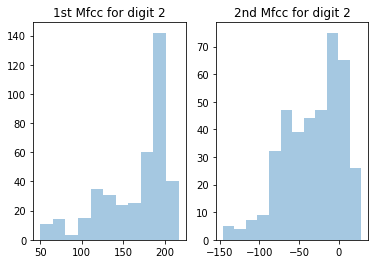

In [11]:
n1 = 2

flat_tmp,flat_tmp2,indices_n1 = find_mfcc1_mfcc2_allspeakers(mfcc13,n1)

f, axes = plt.subplots(1, 2)

sns.distplot(flat_tmp, kde=False, rug=False, ax=axes[0])
axes[0].set_title('1st Mfcc for digit 2')
sns.distplot(flat_tmp2, kde=False, rug=False, ax=axes[1])
axes[1].set_title('2nd Mfcc for digit 2')

Text(0.5, 1.0, '2nd Mfcc for digit 5')

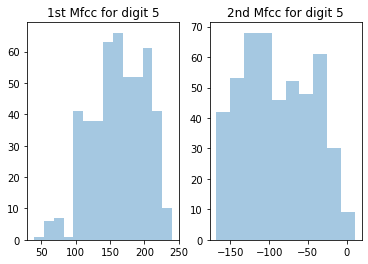

In [12]:
n2 = 5

flat_tmp,flat_tmp2,indices_n2 = find_mfcc1_mfcc2_allspeakers(mfcc13,n2)

f, axes = plt.subplots(1, 2)

sns.distplot(flat_tmp, kde=False, rug=False, ax=axes[0])
axes[0].set_title('1st Mfcc for digit 5')
sns.distplot(flat_tmp2, kde=False, rug=False, ax=axes[1])
axes[1].set_title('2nd Mfcc for digit 5')

As each MFCC is generated by a triangular window sill from a specific frequency range, what we see is that at the lower frequencies (1st MFCC), we have more information than at the higher frequencies. This distance is evident even in two relatively small (hence near coefficients) as we have a small total number of MFCCs. So the deviation we see is 60 units in the second case, while in the first, it is 20 units, because there is enough information gathered at the highest frequencies.

Next, we graphically represent the spectrograms for 2 pronunciations of n1 and n2 by 2 different speakers the mfccs, using the librosa.display.specshow function after first scaling the mffcs so that they have zero mean value and a scatter equal to one.

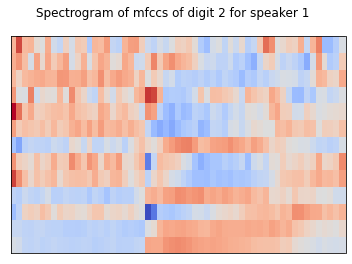

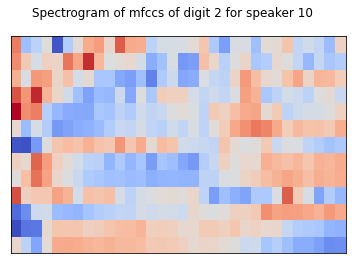

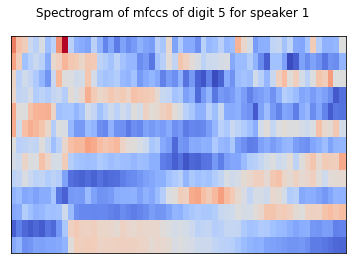

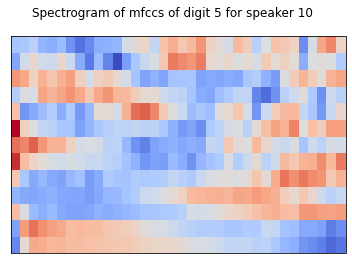

In [13]:
fig = plt.figure()
fig.suptitle('Spectrogram of mfccs of digit '+ str(n1)+ ' for speaker '+str(speakers[indices_n1[0]]))
mfcc = scale(mfcc13[indices_n1[0]],axis=1)
librosa.display.specshow(mfcc, sr=16000)

fig = plt.figure()
fig.suptitle('Spectrogram of mfccs of digit '+ str(n1)+ ' for speaker '+str(speakers[indices_n1[1]]))
mfcc = scale(mfcc13[indices_n1[1]],axis=1)
librosa.display.specshow(mfcc, sr=16000)

fig = plt.figure()
fig.suptitle('Spectrogram of mfccs of digit '+ str(n2)+ ' for speaker '+str(speakers[indices_n2[0]]))
mfcc = scale(mfcc13[indices_n2[0]],axis=1)
librosa.display.specshow(mfcc, sr=16000)

fig = plt.figure()
fig.suptitle('Spectrogram of mfccs of digit '+ str(n2)+ ' for speaker '+str(speakers[indices_n2[1]]))
mfcc = scale(mfcc13[indices_n2[1]],axis=1)
librosa.display.specshow(mfcc, sr=16000)

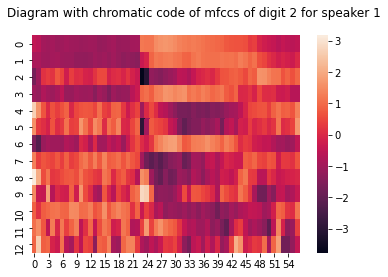

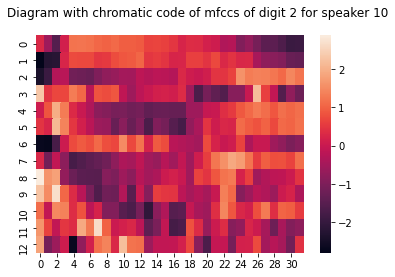

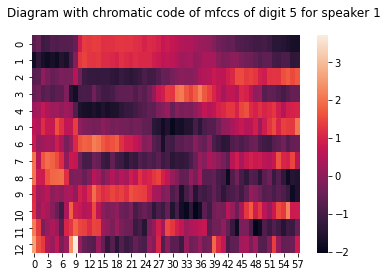

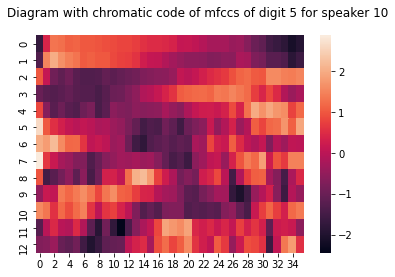

In [14]:
fig = plt.figure()
fig.suptitle('Diagram with chromatic code of mfccs of digit '+ str(n1)+ ' for speaker '+str(speakers[indices_n1[0]]))
mfcc = scale(mfcc13[indices_n1[0]],axis=1)
sns.heatmap(mfcc)

fig = plt.figure()
fig.suptitle('Diagram with chromatic code of mfccs of digit '+ str(n1)+ ' for speaker '+str(speakers[indices_n1[1]]))
mfcc = scale(mfcc13[indices_n1[1]],axis=1)
sns.heatmap(mfcc)

fig = plt.figure()
fig.suptitle('Diagram with chromatic code of mfccs of digit '+ str(n2)+ ' for speaker '+str(speakers[indices_n2[0]]))
mfcc = scale(mfcc13[indices_n2[0]],axis=1)
sns.heatmap(mfcc)

fig = plt.figure()
fig.suptitle('Diagram with chromatic code of mfccs of digit '+ str(n2)+ ' for speaker '+str(speakers[indices_n2[1]]))
mfcc = scale(mfcc13[indices_n2[1]],axis=1)
sns.heatmap(mfcc)

The advantage of color coding diagrams is that the frequencies that contain the most information are easily identified for each MFCC.

In the spectrogram we can easily distinguish the similarities that the different MFCCs have between the different pronunciations of each digit.

We use MFCCs, because with this method we keep only the information that is useful to us so that we can later identify which digit is being spoken. Having STFT we have a large amount of information that is unnecessary and that does not help in the recognition of digits.

# STEP 5 #
It is necessary to identify the digits to extract a unique vector of features for each pronunciation. To do this, we then join the mfcc13, mfcc_delta1, mfcc_delta2 attribute tables for each utterance and create an attribute vector taking the mean and standard deviation of each attribute for all utility windows. We use the functions np.mean, np.var on the attribute table of each pronunciation (dimensional vectors (13.1) are obtained) and np.concetenate to combine the individual attributes into a single vector per pronunciation (dimension (78.1)) , since we have 39 characteristics calculated with the mean value and 39 with the standard deviation). Finally, the data set we create is a numpy array with 133 utterances - samples and 78 attributes per sample, as shown below.

In [15]:
n_chars = (np.shape(mfcc13[0])[0] + np.shape(mfcc_delta1[0])[0] + np.shape(mfcc_delta2[0])[0])*2

chars_all_wav = np.zeros((n_files,n_chars))

for i in range(0,n_files):
    chars_per_wav = np.concatenate((np.mean(mfcc13[i],axis=1),np.mean(mfcc_delta1[i],axis=1),np.mean(mfcc_delta2[i],axis=1),np.var(mfcc13[i],axis=1),np.var(mfcc_delta1[i],axis=1),np.var(mfcc_delta2[i],axis=1)),axis=None)
    chars_all_wav[i] = chars_per_wav

print("The created Data Set is")
print(chars_all_wav)
print("With samples, features = ",np.shape(chars_all_wav))

The created Data Set is
[[-5.15052002e+02  1.15792404e+02 -4.02045135e+01 ...  4.91220690e-02
   9.56944525e-02  3.53522114e-02]
 [-5.13930298e+02  1.19887970e+02 -4.47346191e+01 ...  1.34274274e-01
   7.12222904e-02  9.21158493e-02]
 [-4.96697571e+02  1.19076538e+02 -4.95965080e+01 ...  8.18950757e-02
   1.14398226e-01  3.76580656e-02]
 ...
 [-5.27483215e+02  1.70735168e+02 -3.47066727e+01 ...  7.44966567e-02
   1.62645519e-01  1.49780512e-01]
 [-5.28690735e+02  1.70232819e+02 -2.80068340e+01 ...  6.75862506e-02
   9.38605294e-02  4.69007827e-02]
 [-5.22813538e+02  1.78501282e+02 -3.81180687e+01 ...  1.33129045e-01
   6.71225861e-02  4.42897491e-02]]
With samples, features =  (90, 78)


In [16]:
def scatter_plot_2chars(X_new, digits, title):
    X0, X1 = X_new[:, 0], X_new[:, 1]
    fig,ax = plt.subplots()
    colour_label = ['blue','red','green','pink','black','yellow','orange','grey','purple']

    count = 0
    for label_d in range(9):
        indices_d = [i for i, x in enumerate(digits) if x == label_d]
        count_labels = 0
        for j in indices_d:
            if count_labels == 0:
                plt.scatter(X0[j], X1[j],c=colour_label[count],label = digits[j]+1,s=60, alpha=0.9, edgecolors='k')
            else:
                plt.scatter(X0[j], X1[j],c=colour_label[count],s=60, alpha=0.9, edgecolors='k')
            count_labels = count_labels + 1
        count = count + 1

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

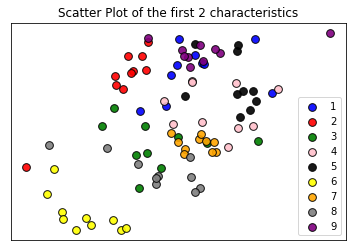

In [17]:
X_new = chars_all_wav[:,[0,1]]
title = "Scatter Plot of the first 2 characteristics"
scatter_plot_2chars(X_new, digits, title)

We observe that in the resulting scatter plot, using two random characteristics for all samples, it is not possible to separate the samples into different categories of digits. To design the separation surface of the various categories we normally need all the features (or as many as possible) to be able to comment on the positions of the digits in relation to the areas they define on the surface. This is due to the fact that the values ​​of the samples of a digit may differ greatly in the two randomly selected characteristics and are placed in quite different places in the 2 regions.

Despite this failure, due to the incomplete characteristics used, we observe that several samples belonging to the same category tend to be concentrated in one area in the diagram.

# STEP 6 #


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

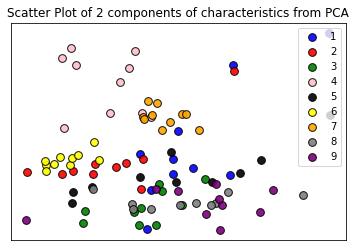

In [18]:
pca = PCA(n_components=2)
pca.fit(chars_all_wav)
X_new = pca.transform(chars_all_wav)
title = "Scatter Plot of 2 components of characteristics from PCA"
scatter_plot_2chars(X_new, digits, title)

In [19]:
def scatter_plot_3chars(X_new, digits, title):
    X0, X1, X2 = X_new[:, 0], X_new[:, 1], X_new[:, 2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colour_label = ['blue','red','green','pink','black','yellow','orange','grey','purple']

    count = 0
    for label_d in range(9):
        indices_d = [i for i, x in enumerate(digits) if x == label_d]
        count_labels = 0
        for j in indices_d:
            if count_labels == 0:
                ax.scatter(X0[j], X1[j], X2[j], c=colour_label[count],label = digits[j]+1,s=60, alpha=0.9, edgecolors='k')
            else:
                ax.scatter(X0[j], X1[j], X2[j], c=colour_label[count],s=60, alpha=0.9, edgecolors='k')
            count_labels = count_labels + 1
        count = count + 1

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_zticks(())
    ax.set_title(title)
    ax.legend()
    return plt


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

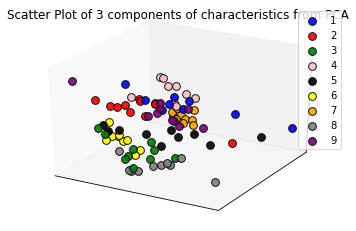

In [20]:
pca = PCA(n_components=3)
pca.fit(chars_all_wav)
X_new = pca.transform(chars_all_wav)
title = "Scatter Plot of 3 components of characteristics from PCA"
scatter_plot_3chars(X_new, digits, title)

We observe that for 3 PCA components the scatter plot improves considerably in terms of separating the samples into different categories. Also, most samples with the same label are collected in common areas with small deviations.

With the PCA technique we reduce the dimensions, finding a new set of features - components, which are complex from the original features, but are not interconnected. Specifically, PCA calculates a new set of variables (main components) and expresses the data based on these new variables. The new variables represent the same amount of information as the original variables. In addition, the overall dispersion remains the same. However, it redistributes between new variables in the most "unequal" way: the first variable not only expresses the largest dispersion between the new variables, but also the largest dispersion that an individual variable can explain. The first component represents the largest possible dispersion in the data, the second represents the second largest dispersion, etc.

# STEP 7 #


In [21]:
X_train, X_test, y_train, y_test = train_test_split(chars_all_wav, np.asarray(digits), test_size=0.3, random_state=42)
print("Dimensions of X_train are", np.shape(X_train))
print("Dimensions of X_test are", np.shape(X_test))
print("Dimensions of Y_train are", np.shape(y_train))
print("Dimensions of Y_test are", np.shape(y_test))
'''
scaler = MinMaxScaler(feature_range=(-1,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) '''

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 
'''
X_train = scale(X_train)
X_test = scale(X_test) '''

Dimensions of X_train are (63, 78)
Dimensions of X_test are (27, 78)
Dimensions of Y_train are (63,)
Dimensions of Y_test are (27,)


'\nX_train = scale(X_train)\nX_test = scale(X_test) '

In [22]:
class BayesianClassifier(BaseEstimator, ClassifierMixin):  

    def __init__(self):
        self.X_mean_ = None
        self.X_variance_ = None
        self.a_priori_ = None

    def calculate_a_priori(self, Y_train):
        a_priori_dict = dict()
        labels = len(np.unique(Y_train))
        res_a_priori = np.zeros(labels)

        n = Y_train.shape[0]
        for item in Y_train:
            if item in a_priori_dict:
                a_priori_dict[item] += 1
            else:
                a_priori_dict[item] = 1

        for key,value in a_priori_dict.items():
            a_priori_dict[key] = value/n
        sortapriori = sorted(a_priori_dict)
        for key in sortapriori:
            res_a_priori[int(key)] = a_priori_dict[key]
        return res_a_priori

    def fit(self, X, y, forced_variance = None):
        
        X, y = check_X_y(X, y)
        
        labels = len(np.unique(y))
        
        self.X_mean_ = np.zeros((labels, X.shape[1]))
        self.X_variance_ = np.zeros((labels, X.shape[1]))
        self.a_priori_ = self.calculate_a_priori(y)
        for i in range(labels):
            class_data = X[y == i]
            for j in range(X.shape[1]):
                self.X_mean_[i,j] = np.average(class_data[:,j])
                if forced_variance == None:
                    self.X_variance_[i,j] = np.var(class_data[:,j])
                else:
                    self.X_variance_[i,j] = 1
                
            
        return self

    def calculateProbability(self, x, mean, var):
        exponent = math.exp(-(math.pow(x-mean,2)/(2*var)))
        return (1 / (math.sqrt(2*math.pi * var))) * exponent

    def predict(self, X):
        
        try:
            getattr(self, "X_mean_")
            getattr(self, "X_variance_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        
        prob = np.zeros(9)
        class_predictions = np.zeros(X.shape[0])
        for i in range(class_predictions.shape[0]):
            test_sample = X[i,:]
            for j in range(9): 
                prob[j] = 1
               
                for k in range(test_sample.shape[0]):
                    if self.X_variance_[j,k] == 0:
                        continue
                    x = test_sample[k]
                    mean = self.X_mean_[j,k]
                    var = self.X_variance_[j,k]
                    
                    curr_prob = self.calculateProbability(x , mean, var)
                    prob[j] *= curr_prob      
                prob[j] *= self.a_priori_[j]
            class_predictions[i] = np.argmax(prob) # find the biggest probability
        return class_predictions
    
    def score(self, X, y):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        return accuracy_score(y, self.predict(X))

In [23]:
custom_gauss = BayesianClassifier()
custom_gauss.fit(X_train, y_train)
score0 = custom_gauss.score(X_test, y_test)
print("Success rate of our Naive Bayes is",score0*100,"%")

Success rate of our Naive Bayes is 100.0 %


In [24]:
clf_gauss = GaussianNB()
clf_gauss.fit(X_train, y_train)
score1 = clf_gauss.score(X_test, y_test)
print("Success rate of scikit-learn GaussianNB is",score1*100,"%")

clf_kneigh = KNeighborsClassifier()
clf_kneigh.fit(X_train, y_train)
score2 = clf_kneigh.score(X_test,y_test)
print("Success rate of scikit-learn KNeighborsClassifier is",score2*100,"%")

clf_linear = svm.SVC(kernel='linear', probability = True, random_state=100)
clf_linear.fit(X_train, y_train)
score3 = clf_linear.score(X_test,y_test)
print("Success rate of scikit-learn svm with kernel='linear' is",score3*100,"%")

clf_tree = DecisionTreeClassifier(random_state=100)
clf_tree.fit(X_train, y_train)
score4 = clf_tree.score(X_test,y_test)
print("Success rate of scikit-learn DecisionTreeClassifier is",score4*100,"%")

Success rate of scikit-learn GaussianNB is 100.0 %
Success rate of scikit-learn KNeighborsClassifier is 96.29629629629629 %
Success rate of scikit-learn svm with kernel='linear' is 100.0 %
Success rate of scikit-learn DecisionTreeClassifier is 85.18518518518519 %


# STEP 8 #
For the implementation of the Recurrent Neural Network (RNN), the auxiliary code was used as a basis and a class BasicLSTM class (nn.Module) was created with the methods init, forward. To apply a layer to a point sequence, the apply_layer_to_timesteps function was used, which was also in the helper. Next in different cells follow the calculation of the apply_layer_to_timesteps function, the implementation of the RNN class and finally the production of the 10 point sequences of a sine and a cosine with frequency f = 40 Hz together with the train loop.

In the train loop, the RNN training that we implemented takes place, feeding it each time with a sequence of 10 sine points. The neuron returns a prediction for the corresponding cosine sequence, and the MSE loss (mean square error) is calculated relative to the actual cosine sequence corresponding to the sequence. We do back propagation in error with loss.backward (). For the renewal of the neuron weights we use the optimizer.step () with the optimizer torch.optim.Adam. The .backward () slope accumulates the gradients for each parameter, so we call the optimizer.zero_grad () for each .step () call.

Select the following parameters which we set before the train loop: INPUT_SIZE = 1 (rnn input size), TIME_STEP = 10 (rnn time step), LR = 0.02 (learning rate), hidden_dim = 32 (number of features in the hidden state h), num_layers = 2 (number of recurrent layer), output_dim = 1 (rnn output size).

To create the sine, cosine sequences we choose: f = 40 (frequency for the sine, cosine sequences), len_seq = 10 (number of points of each sequence), n_samples = 100 (number of different sine, cosine) sequences, step = 0.001 (distance between the successive points of each sequence).

In each cycle of the train loop we create in a common graph the prediction for the cosine for a specific sequence of points and the real cosine that corresponds to them. We see that gradually the prediction converges to the real sequence.

We use RNN / LSTM because LSTM networks are very good at maintaining long-term memory. In other words, predicting the nth sample in a sample sequence can be affected by an input given many steps ago. The network can store or release memory on the go through the gateway mechanism. LSTM is a good choice for such data sequences, which have long dependencies on it. More specifically, during back propagation, RNNs suffer from the so-called "vanishing gradient problem". Gradients are the values ​​used to inform the weights of neural networks. The "vanishing gradient problem" is when the gradient shrinks as it is transmitted back over time. If a gradient value becomes extremely small, it does not contribute much to learning. In RNN the layers that receive a small gradient update stop learning and in large sequences this leads to short term memory. LSTMs and GRUs have internal mechanisms called gateways that can regulate the flow of information.

In [25]:
# Help for Step 8

# 1) Use MSE loss function
# 2) Inside the train loop, if you shaped your input features into a 2D array, 
#    augment their dimensionality by 1 before feeding a batch of them in the LSTM as the batch must be a 3D array, not 2D.
#    The command for doing this is: your_batch.unsqueeze_(-1)
#    and it is an inplace operation, you don't have to assign it to a new variable
#    In the same way, you must .squeeze_() the outputs of the LSTM to reshape them into a 2D array.
# 3) In order to apply a neural network layer to a sequence you must use the given function: apply_layer_to_timesteps
# 4) The input sequences in the main part of the exercise will not be of the same length. For this reason, we use
#    the PyTorch helper functions: pack_padded_sequence and pad_packed sequence. Note that these functions do not pad
#    the sequences, we still have to do this operation manually before feeding the data into the LSTM.

def apply_layer_to_timesteps(x, layer, batch_first=True):
    # Reshape x into a flat array
    x_reshape = x.contiguous().view(-1, x.size(-1))
    # Apply the layer
    y = layer(x_reshape)
    # Reshape y to previous form
    if batch_first:
        y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
    else:
        y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

    return y
  
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim = 1, num_layers=2):
        super(BasicLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        # Implement the init function

    def forward(self, features, lengths, batch_first):
        """ Features: N x L x D
            N: batch index
            L: sequence index
            D: feature index
            lengths: N x 1 -> lengths of sequences (needed for pack_padded_sequence nad pad_packed_sequence)
         """
        # Use pack_padded_sequence to create a PackedSequence for inputs of different length
        packed = pack_padded_sequence(features, lengths, batch_first=True)
        # Pass the whole packed sequence from the LSTM
        # The LSTM also returns the hidden state which we do not need here
        output, _ = self.lstm(packed)
        # Return output in the same form as the input we gave in the pack_padded_sequence function
        output, _ = pad_packed_sequence(output, batch_first=True)
        
        y_pred = apply_layer_to_timesteps(output, self.linear, batch_first)
        return y_pred.view(-1)

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0406, -0.0566, -0.0654, -0.0702, -0.0728, -0.0742, -0.0750, -0.0754,
        -0.0758, -0.0762], grad_fn=<ViewBackward0>)


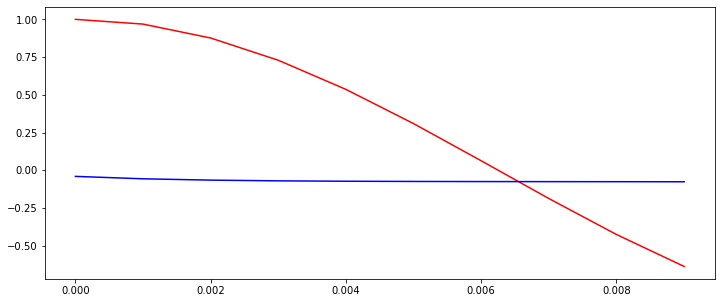

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([0.0345, 0.0524, 0.0621, 0.0655, 0.0643, 0.0603, 0.0551, 0.0498, 0.0456,
        0.0431], grad_fn=<ViewBackward0>)


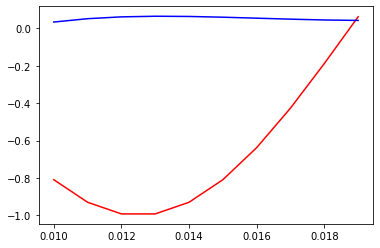

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0317, -0.0388, -0.0347, -0.0253, -0.0131,  0.0003,  0.0137,  0.0262,
         0.0370,  0.0455], grad_fn=<ViewBackward0>)


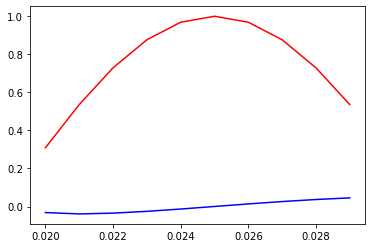

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([0.0393, 0.0526, 0.0564, 0.0554, 0.0513, 0.0450, 0.0370, 0.0278, 0.0180,
        0.0082], grad_fn=<ViewBackward0>)


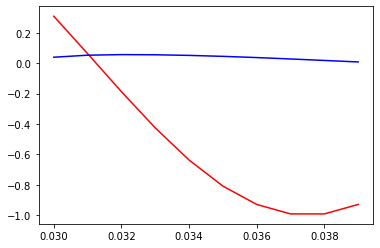

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0098, -0.0153, -0.0172, -0.0170, -0.0152, -0.0121, -0.0079, -0.0027,
         0.0029,  0.0086], grad_fn=<ViewBackward0>)


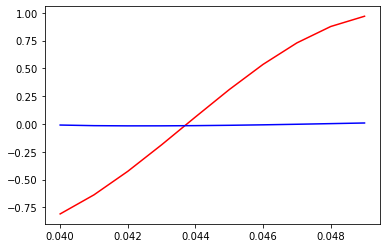

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([ 0.0025,  0.0050,  0.0060,  0.0048,  0.0021, -0.0016, -0.0058, -0.0100,
        -0.0137, -0.0168], grad_fn=<ViewBackward0>)


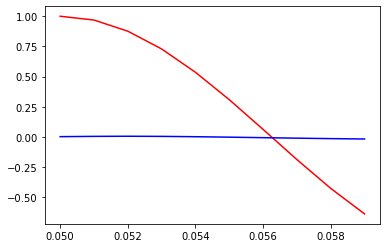

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0115,  0.0009, -0.0070, -0.0095, -0.0074, -0.0023,  0.0043,  0.0115,
         0.0184,  0.0246], grad_fn=<ViewBackward0>)


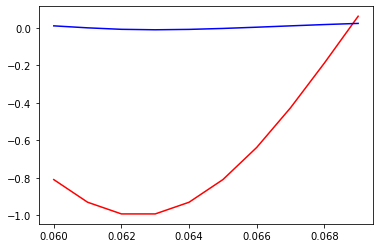

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0071,  0.0051,  0.0163,  0.0220,  0.0223,  0.0181,  0.0102, -0.0004,
        -0.0125, -0.0252], grad_fn=<ViewBackward0>)


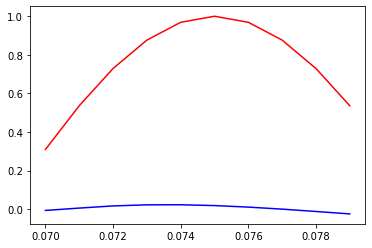

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0036, -0.0223, -0.0462, -0.0630, -0.0725, -0.0753, -0.0722, -0.0636,
        -0.0503, -0.0336], grad_fn=<ViewBackward0>)


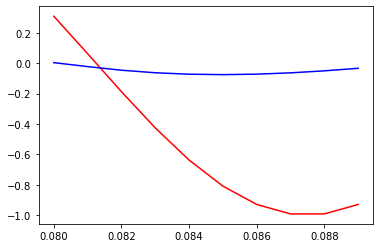

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([0.0040, 0.0192, 0.0393, 0.0591, 0.0757, 0.0876, 0.0942, 0.0951, 0.0902,
        0.0792], grad_fn=<ViewBackward0>)


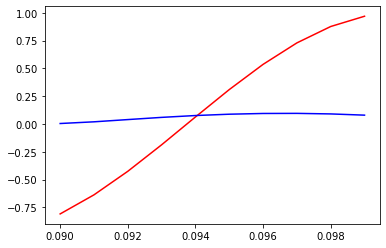

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0008, -0.0112, -0.0325, -0.0624, -0.0972, -0.1325, -0.1648, -0.1913,
        -0.2103, -0.2209], grad_fn=<ViewBackward0>)


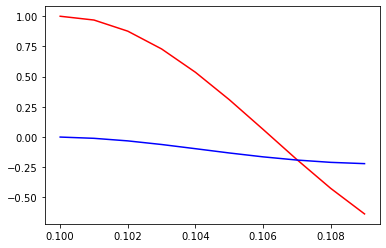

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([-0.0088, -0.0457, -0.0680, -0.0692, -0.0501, -0.0144,  0.0319,  0.0819,
         0.1288,  0.1678], grad_fn=<ViewBackward0>)


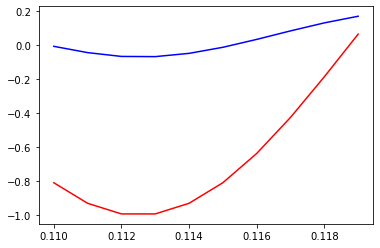

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([ 0.0205,  0.0782,  0.1288,  0.1602,  0.1706,  0.1609,  0.1322,  0.0855,
         0.0225, -0.0527], grad_fn=<ViewBackward0>)


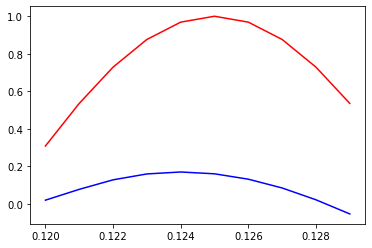

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([-0.0284, -0.1258, -0.2315, -0.3254, -0.3996, -0.4531, -0.4874, -0.5041,
        -0.5039, -0.4862], grad_fn=<ViewBackward0>)


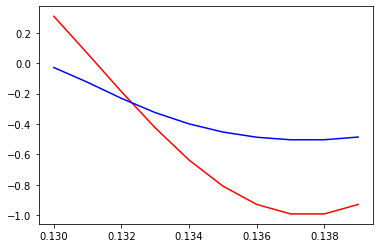

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([0.0285, 0.1036, 0.2077, 0.3161, 0.4079, 0.4747, 0.5180, 0.5429, 0.5535,
        0.5525], grad_fn=<ViewBackward0>)


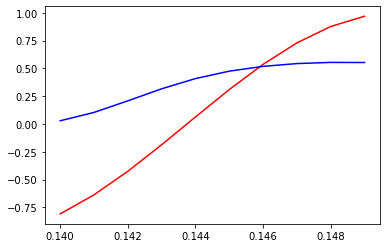

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([ 5.7755e-04, -2.3617e-02, -9.0614e-02, -2.0856e-01, -3.6956e-01,
        -5.4621e-01, -7.0541e-01, -8.2923e-01, -9.1769e-01, -9.7907e-01],
       grad_fn=<ViewBackward0>)


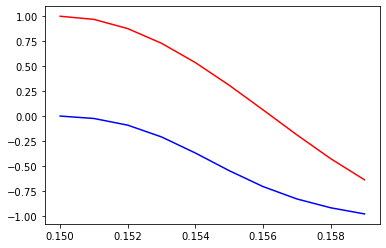

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([-0.0134, -0.0974, -0.1828, -0.2507, -0.2924, -0.3019, -0.2740, -0.2029,
        -0.0849,  0.0751], grad_fn=<ViewBackward0>)


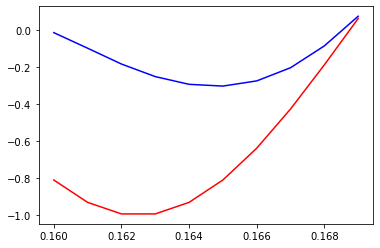

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([0.0446, 0.1889, 0.3572, 0.5053, 0.6151, 0.6885, 0.7343, 0.7602, 0.7722,
        0.7744], grad_fn=<ViewBackward0>)


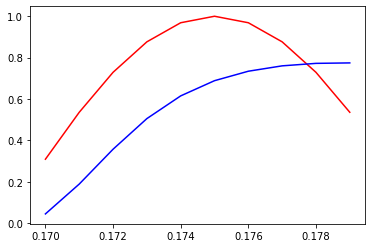

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([-0.0196, -0.1760, -0.3743, -0.5562, -0.6936, -0.7894, -0.8565, -0.9057,
        -0.9435, -0.9734], grad_fn=<ViewBackward0>)


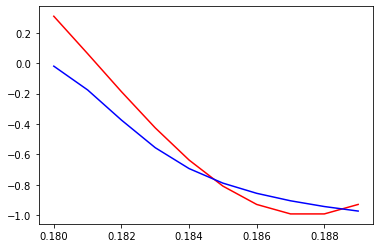

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([0.0370, 0.1596, 0.3657, 0.6003, 0.7971, 0.9349, 1.0219, 1.0734, 1.1027,
        1.1189], grad_fn=<ViewBackward0>)


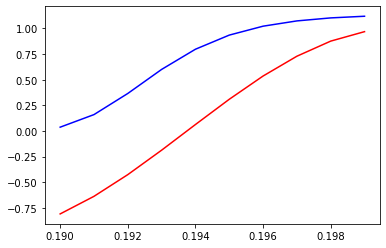

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([ 0.0127,  0.0040, -0.0508, -0.1706, -0.3431, -0.5139, -0.6398, -0.7209,
        -0.7736, -0.8116], grad_fn=<ViewBackward0>)


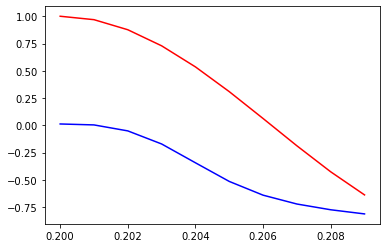

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0173, -0.0702, -0.1847, -0.3095, -0.4351, -0.5521, -0.6525, -0.7316,
        -0.7889, -0.8266], grad_fn=<ViewBackward0>)


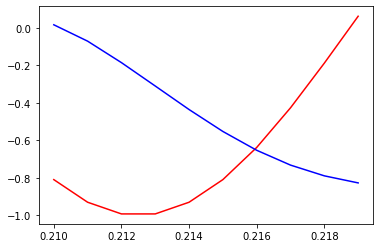

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([0.0082, 0.1309, 0.2965, 0.4446, 0.5465, 0.6083, 0.6450, 0.6679, 0.6830,
        0.6932], grad_fn=<ViewBackward0>)


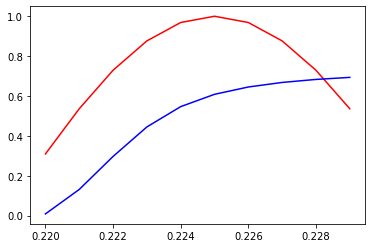

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0448, -0.0460, -0.1749, -0.2905, -0.3720, -0.4269, -0.4680, -0.5028,
        -0.5346, -0.5638], grad_fn=<ViewBackward0>)


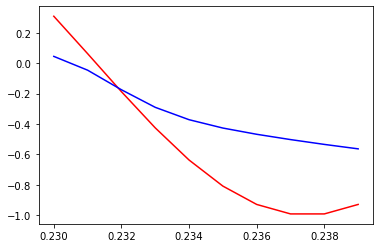

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([0.0113, 0.0842, 0.2176, 0.3609, 0.4661, 0.5290, 0.5637, 0.5835, 0.5964,
        0.6064], grad_fn=<ViewBackward0>)


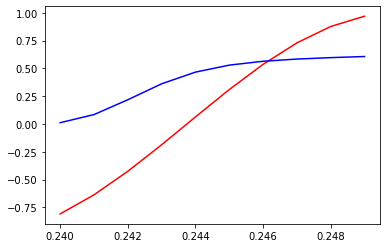

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([ 0.0252,  0.0443,  0.0439,  0.0069, -0.0738, -0.1789, -0.2691, -0.3286,
        -0.3665, -0.3950], grad_fn=<ViewBackward0>)


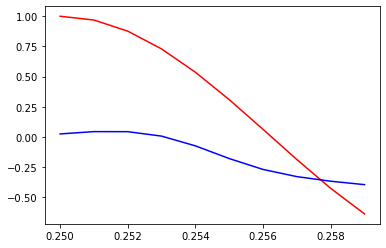

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 5.3510e-02, -1.2864e-04, -7.3555e-02, -1.5117e-01, -2.2734e-01,
        -2.9875e-01, -3.6291e-01, -4.1778e-01, -4.6163e-01, -4.9324e-01],
       grad_fn=<ViewBackward0>)


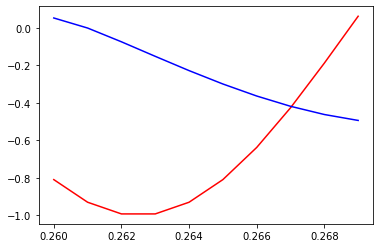

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0142,  0.0887,  0.2363,  0.3671,  0.4554,  0.5084,  0.5411,  0.5635,
         0.5804,  0.5932], grad_fn=<ViewBackward0>)


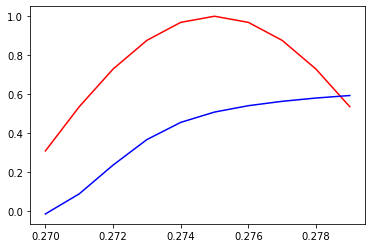

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0763,  0.0082, -0.1033, -0.2094, -0.2863, -0.3393, -0.3800, -0.4152,
        -0.4475, -0.4770], grad_fn=<ViewBackward0>)


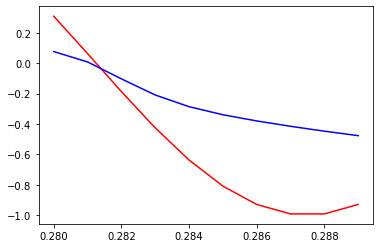

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([0.0077, 0.0905, 0.2435, 0.4060, 0.5289, 0.6062, 0.6513, 0.6787, 0.6978,
        0.7134], grad_fn=<ViewBackward0>)


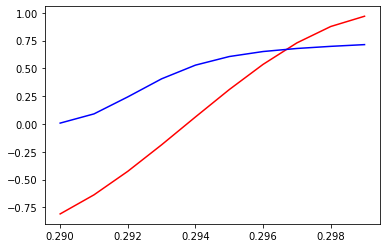

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([ 0.0308,  0.0694,  0.0996,  0.1038,  0.0675, -0.0199, -0.1461, -0.2673,
        -0.3537, -0.4109], grad_fn=<ViewBackward0>)


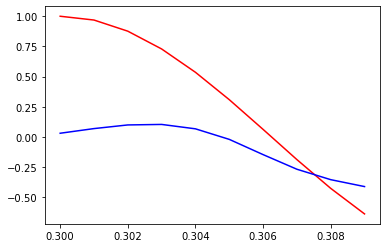

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0635,  0.0113, -0.0584, -0.1250, -0.1797, -0.2158, -0.2271, -0.2047,
        -0.1349,  0.0005], grad_fn=<ViewBackward0>)


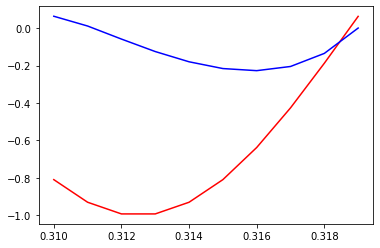

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0155,  0.1345,  0.3549,  0.5602,  0.7091,  0.8037,  0.8615,  0.8981,
         0.9222,  0.9383], grad_fn=<ViewBackward0>)


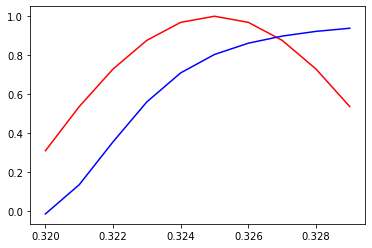

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0727, -0.0375, -0.2169, -0.3820, -0.4934, -0.5643, -0.6145, -0.6545,
        -0.6887, -0.7183], grad_fn=<ViewBackward0>)


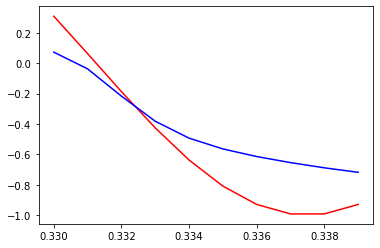

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0038,  0.1124,  0.3299,  0.5558,  0.7261,  0.8348,  0.8991,  0.9392,
         0.9678,  0.9910], grad_fn=<ViewBackward0>)


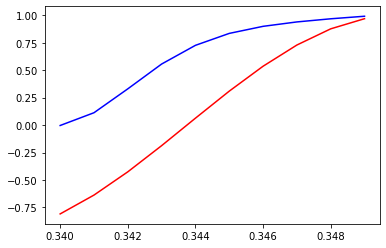

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([ 0.0137,  0.0470,  0.0580,  0.0096, -0.1272, -0.3261, -0.4982, -0.6067,
        -0.6707, -0.7133], grad_fn=<ViewBackward0>)


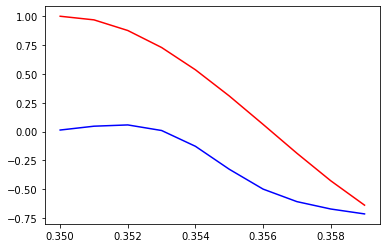

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0510, -0.0460, -0.1963, -0.3730, -0.5470, -0.6882, -0.7863, -0.8488,
        -0.8865, -0.9072], grad_fn=<ViewBackward0>)


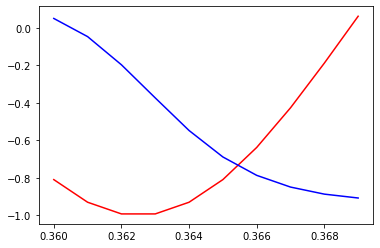

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0517,  0.1028,  0.3274,  0.5197,  0.6541,  0.7416,  0.7993,  0.8395,
         0.8687,  0.8898], grad_fn=<ViewBackward0>)


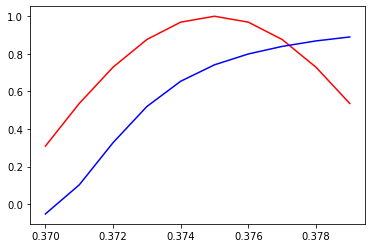

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0800, -0.0433, -0.2603, -0.4636, -0.5986, -0.6792, -0.7315, -0.7708,
        -0.8030, -0.8300], grad_fn=<ViewBackward0>)


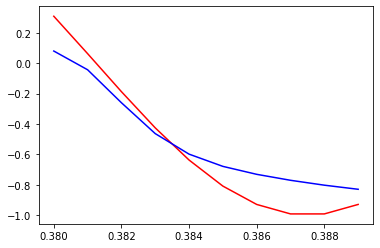

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0355,  0.0634,  0.2423,  0.3973,  0.5001,  0.5656,  0.6098,  0.6453,
         0.6788,  0.7127], grad_fn=<ViewBackward0>)


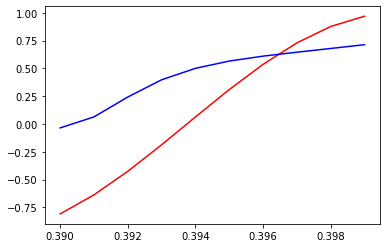

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([ 0.0047,  0.0596,  0.1211,  0.1640,  0.1672,  0.1037, -0.0550, -0.2826,
        -0.4842, -0.6141], grad_fn=<ViewBackward0>)


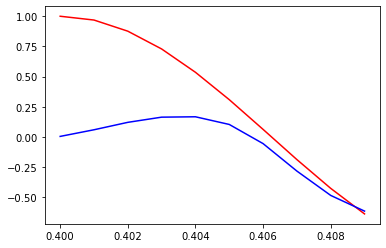

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0649, -0.0096, -0.1274, -0.2646, -0.4084, -0.5440, -0.6555, -0.7356,
        -0.7874, -0.8179], grad_fn=<ViewBackward0>)


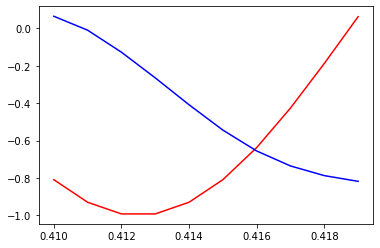

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0846,  0.0504,  0.2361,  0.3877,  0.5014,  0.5848,  0.6471,  0.6954,
         0.7330,  0.7613], grad_fn=<ViewBackward0>)


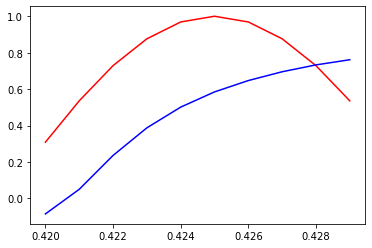

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.1085,  0.0221, -0.1800, -0.4009, -0.5561, -0.6439, -0.6953, -0.7306,
        -0.7575, -0.7790], grad_fn=<ViewBackward0>)


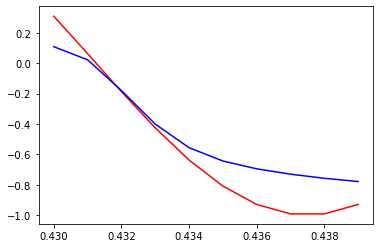

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0515,  0.0528,  0.2161,  0.3422,  0.4293,  0.4898,  0.5362,  0.5793,
         0.6243,  0.6718], grad_fn=<ViewBackward0>)


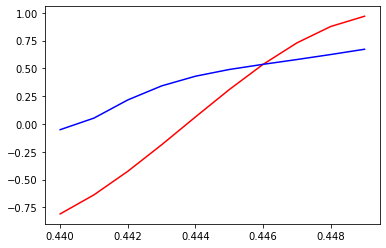

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([0.0064, 0.1122, 0.2844, 0.5014, 0.6996, 0.8243, 0.8854, 0.9097, 0.9138,
        0.9048], grad_fn=<ViewBackward0>)


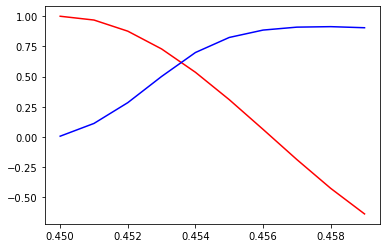

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0721,  0.0303, -0.0149, -0.0144,  0.0692,  0.2023,  0.2938,  0.3442,
         0.3729,  0.3914], grad_fn=<ViewBackward0>)


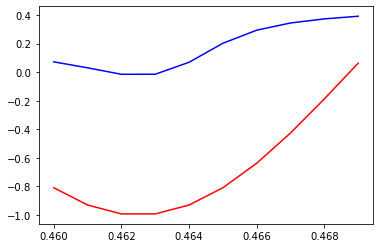

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.1245, -0.0226,  0.1035,  0.1991,  0.2788,  0.3431,  0.3944,  0.4358,
         0.4688,  0.4937], grad_fn=<ViewBackward0>)


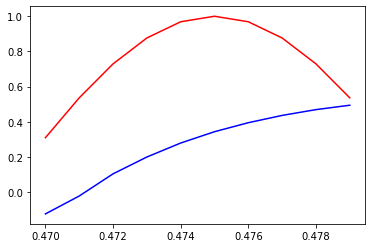

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0994,  0.0159, -0.1788, -0.3918, -0.5428, -0.6240, -0.6694, -0.7004,
        -0.7241, -0.7428], grad_fn=<ViewBackward0>)


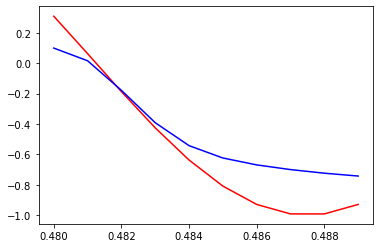

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.1057, -0.0604,  0.0067,  0.0299,  0.0451,  0.0649,  0.0890,  0.1187,
         0.1545,  0.1945], grad_fn=<ViewBackward0>)


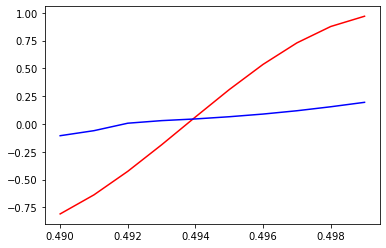

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0378,  0.0215,  0.1087,  0.2049,  0.3025,  0.3878,  0.4324,  0.4281,
         0.4031,  0.3761], grad_fn=<ViewBackward0>)


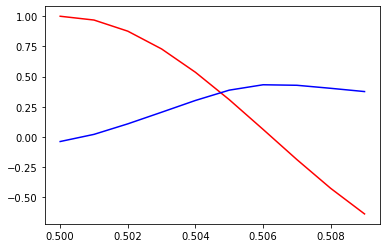

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0384, -0.0578, -0.2117, -0.3949, -0.5634, -0.6834, -0.7543, -0.7922,
        -0.8114, -0.8200], grad_fn=<ViewBackward0>)


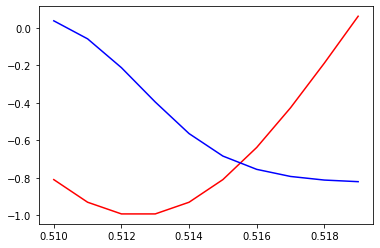

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.1553, -0.0710,  0.0239,  0.0881,  0.1408,  0.1823,  0.2152,  0.2416,
         0.2624,  0.2780], grad_fn=<ViewBackward0>)


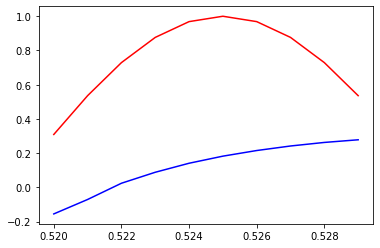

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0725, -0.0584, -0.2952, -0.5205, -0.6535, -0.7155, -0.7497, -0.7740,
        -0.7931, -0.8081], grad_fn=<ViewBackward0>)


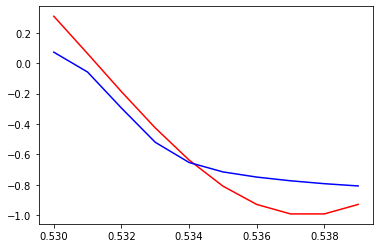

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.1061, -0.0400,  0.0581,  0.1155,  0.1548,  0.1836,  0.2080,  0.2330,
         0.2599,  0.2873], grad_fn=<ViewBackward0>)


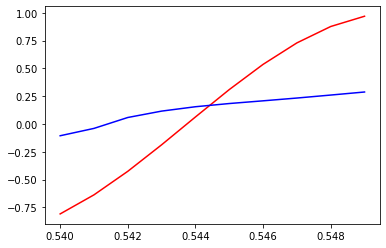

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0422,  0.0024,  0.0486,  0.0579, -0.0182, -0.2172, -0.4639, -0.6478,
        -0.7397, -0.7817], grad_fn=<ViewBackward0>)


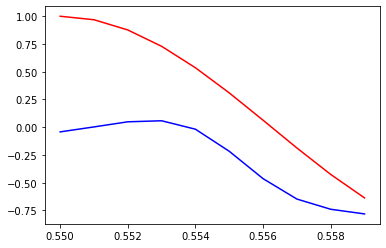

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0269, -0.1025, -0.3034, -0.5210, -0.6841, -0.7771, -0.8227, -0.8440,
        -0.8535, -0.8566], grad_fn=<ViewBackward0>)


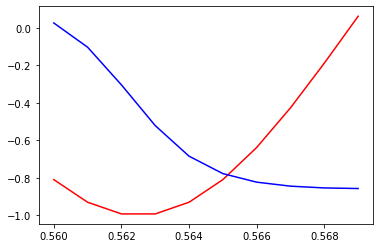

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.1124,  0.0411,  0.2175,  0.3456,  0.4205,  0.4631,  0.4906,  0.5091,
         0.5217,  0.5300], grad_fn=<ViewBackward0>)


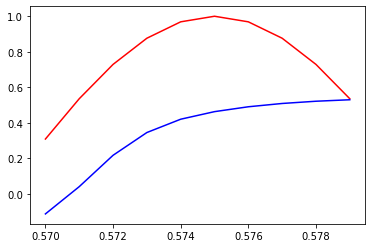

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0646, -0.1042, -0.3620, -0.5673, -0.6755, -0.7236, -0.7485, -0.7651,
        -0.7773, -0.7862], grad_fn=<ViewBackward0>)


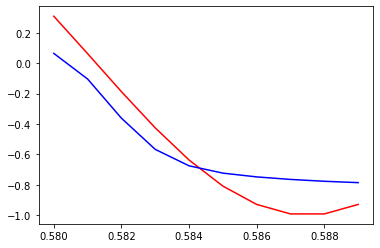

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0612,  0.0815,  0.2720,  0.4134,  0.4932,  0.5349,  0.5633,  0.5874,
         0.6098,  0.6304], grad_fn=<ViewBackward0>)


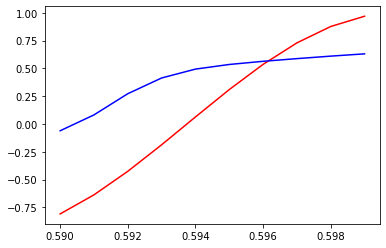

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0112,  0.0895,  0.2470,  0.4379,  0.5934,  0.6744,  0.7094,  0.7238,
         0.7285,  0.7277], grad_fn=<ViewBackward0>)


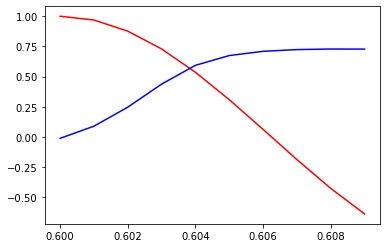

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0423, -0.0632, -0.2184, -0.3986, -0.5543, -0.6503, -0.6972, -0.7180,
        -0.7267, -0.7297], grad_fn=<ViewBackward0>)


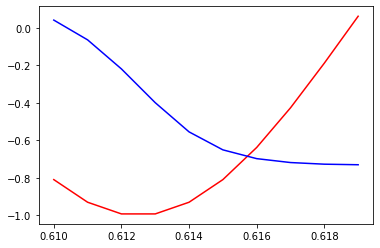

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0721,  0.1337,  0.3691,  0.5289,  0.6045,  0.6419,  0.6631,  0.6755,
         0.6827,  0.6868], grad_fn=<ViewBackward0>)


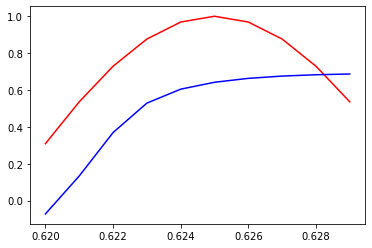

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0699, -0.0953, -0.3386, -0.5093, -0.5897, -0.6240, -0.6408, -0.6512,
        -0.6584, -0.6634], grad_fn=<ViewBackward0>)


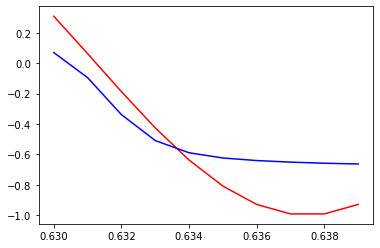

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0416,  0.1317,  0.3493,  0.5002,  0.5718,  0.6066,  0.6295,  0.6477,
         0.6634,  0.6767], grad_fn=<ViewBackward0>)


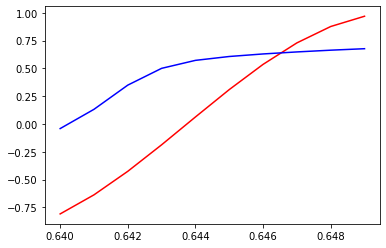

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0041,  0.1181,  0.3099,  0.5029,  0.6119,  0.6548,  0.6714,  0.6781,
         0.6803,  0.6800], grad_fn=<ViewBackward0>)


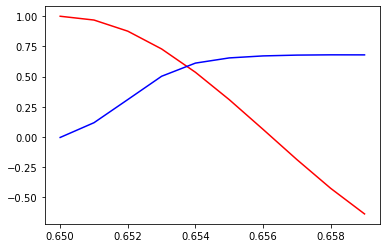

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0407, -0.0510, -0.1805, -0.3320, -0.4735, -0.5693, -0.6163, -0.6344,
        -0.6402, -0.6412], grad_fn=<ViewBackward0>)


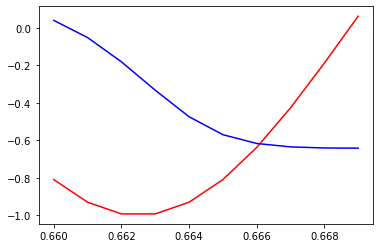

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0733,  0.1272,  0.3423,  0.4684,  0.5182,  0.5412,  0.5527,  0.5582,
         0.5604,  0.5609], grad_fn=<ViewBackward0>)


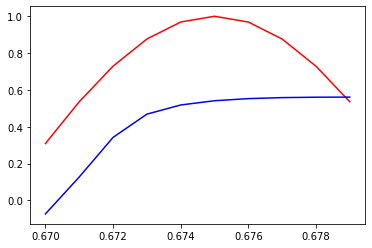

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0619, -0.0940, -0.3216, -0.4828, -0.5572, -0.5866, -0.5993, -0.6059,
        -0.6093, -0.6107], grad_fn=<ViewBackward0>)


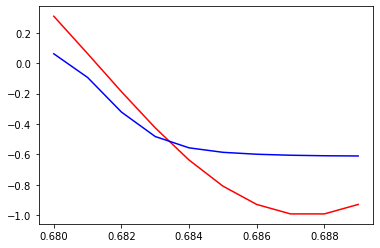

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0538,  0.1074,  0.2953,  0.4100,  0.4576,  0.4809,  0.4967,  0.5092,
         0.5194,  0.5272], grad_fn=<ViewBackward0>)


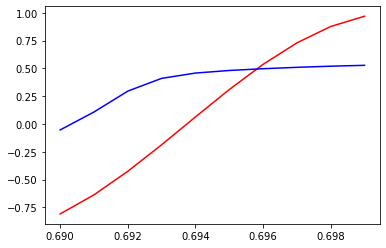

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0184,  0.0945,  0.2658,  0.4151,  0.4772,  0.4948,  0.5017,  0.5047,
         0.5059,  0.5062], grad_fn=<ViewBackward0>)


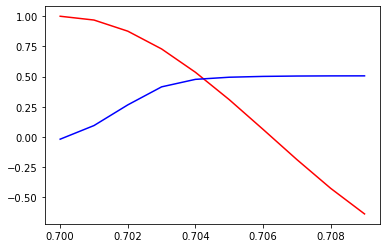

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0262, -0.0788, -0.2393, -0.4248, -0.5636, -0.6310, -0.6538, -0.6584,
        -0.6572, -0.6546], grad_fn=<ViewBackward0>)


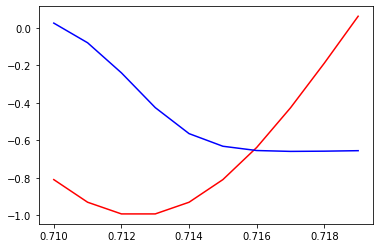

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0876,  0.1042,  0.2905,  0.3829,  0.4128,  0.4253,  0.4297,  0.4300,
         0.4285,  0.4264], grad_fn=<ViewBackward0>)


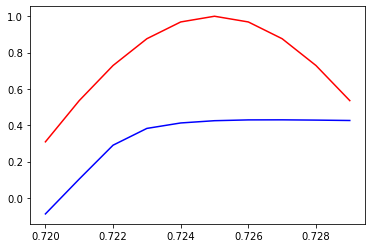

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0460, -0.1278, -0.3832, -0.5728, -0.6600, -0.6909, -0.7014, -0.7042,
        -0.7021, -0.6967], grad_fn=<ViewBackward0>)


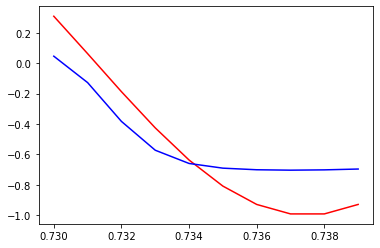

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0663,  0.0953,  0.2673,  0.3600,  0.3952,  0.4128,  0.4250,  0.4340,
         0.4406,  0.4444], grad_fn=<ViewBackward0>)


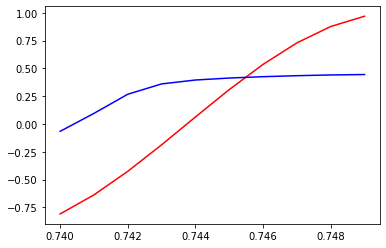

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0310,  0.0778,  0.2417,  0.3751,  0.4151,  0.4198,  0.4222,  0.4236,
         0.4245,  0.4254], grad_fn=<ViewBackward0>)


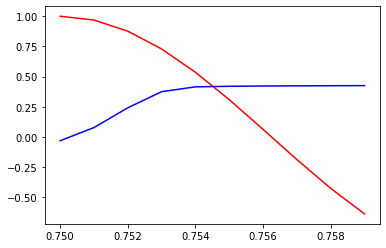

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0131, -0.1203, -0.3351, -0.5575, -0.6931, -0.7460, -0.7569, -0.7529,
        -0.7455, -0.7384], grad_fn=<ViewBackward0>)


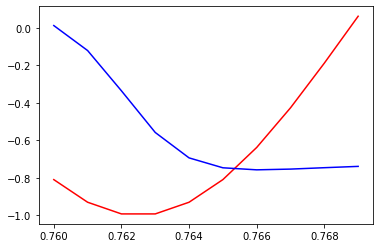

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0917,  0.1118,  0.2946,  0.3739,  0.3948,  0.4015,  0.4013,  0.3979,
         0.3935,  0.3893], grad_fn=<ViewBackward0>)


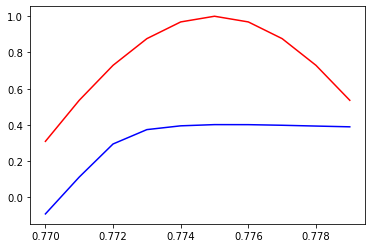

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0327, -0.1804, -0.4871, -0.7054, -0.7973, -0.8251, -0.8314, -0.8287,
        -0.8196, -0.8055], grad_fn=<ViewBackward0>)


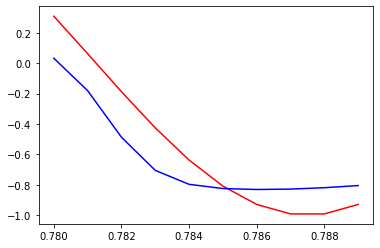

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0678,  0.1082,  0.2861,  0.3769,  0.4099,  0.4266,  0.4375,  0.4446,
         0.4486,  0.4493], grad_fn=<ViewBackward0>)


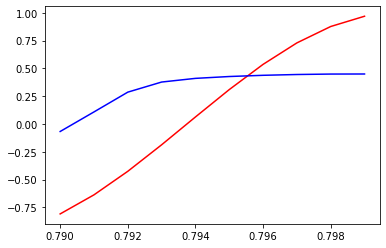

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0340,  0.0761,  0.2449,  0.3845,  0.4198,  0.4179,  0.4178,  0.4184,
         0.4195,  0.4212], grad_fn=<ViewBackward0>)


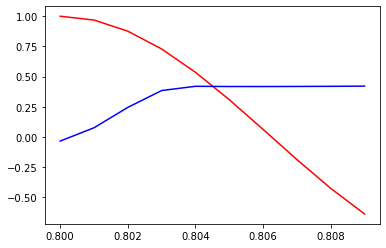

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0097, -0.1511, -0.4060, -0.6282, -0.7333, -0.7566, -0.7482, -0.7329,
        -0.7192, -0.7092], grad_fn=<ViewBackward0>)


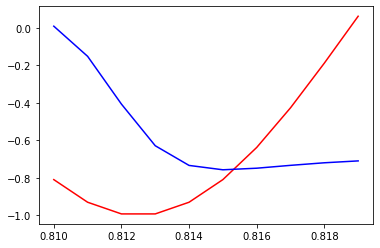

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0875,  0.1278,  0.3222,  0.4047,  0.4223,  0.4250,  0.4208,  0.4136,
         0.4060,  0.3992], grad_fn=<ViewBackward0>)


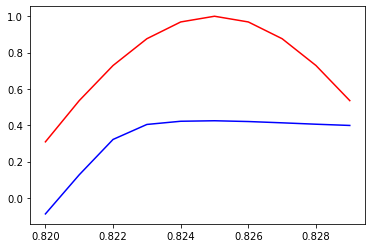

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0319, -0.2063, -0.5253, -0.7275, -0.7995, -0.8134, -0.8092, -0.7962,
        -0.7754, -0.7489], grad_fn=<ViewBackward0>)


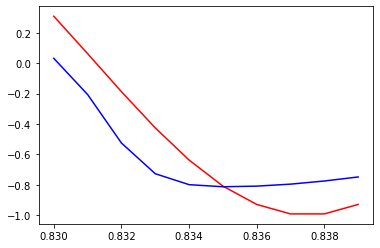

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0635,  0.1233,  0.3150,  0.4168,  0.4539,  0.4721,  0.4830,  0.4890,
         0.4907,  0.4880], grad_fn=<ViewBackward0>)


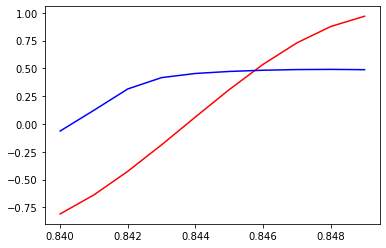

tensor([ 1.0000,  0.9686,  0.8763,  0.7290,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0306,  0.0821,  0.2584,  0.4082,  0.4439,  0.4378,  0.4355,  0.4356,
         0.4369,  0.4397], grad_fn=<ViewBackward0>)


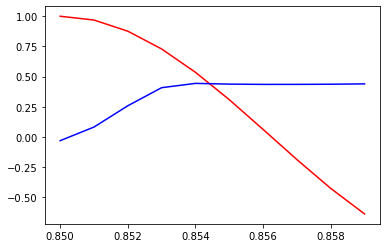

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0147, -0.1645, -0.4332, -0.6231, -0.6823, -0.6731, -0.6475, -0.6259,
        -0.6119, -0.6039], grad_fn=<ViewBackward0>)


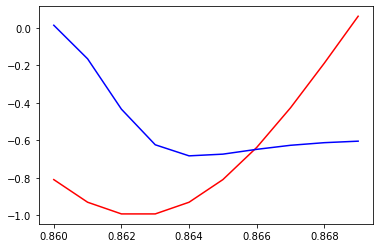

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0829,  0.1391,  0.3504,  0.4447,  0.4623,  0.4617,  0.4531,  0.4413,
         0.4295,  0.4192], grad_fn=<ViewBackward0>)


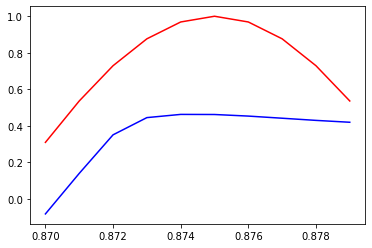

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0385, -0.2133, -0.5300, -0.7127, -0.7706, -0.7773, -0.7683, -0.7501,
        -0.7225, -0.6859], grad_fn=<ViewBackward0>)


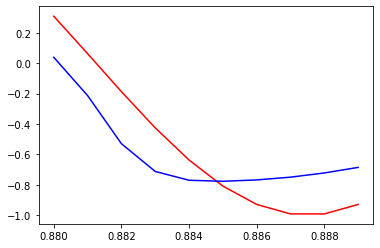

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0605,  0.1342,  0.3399,  0.4573,  0.5028,  0.5247,  0.5370,  0.5425,
         0.5422,  0.5360], grad_fn=<ViewBackward0>)


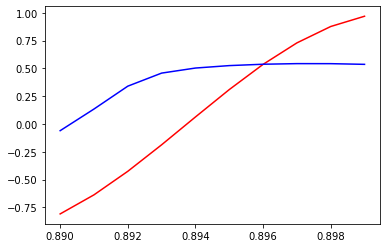

tensor([ 1.0000,  0.9686,  0.8763,  0.7289,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0275,  0.0915,  0.2799,  0.4356,  0.4662,  0.4553,  0.4508,  0.4500,
         0.4514,  0.4555], grad_fn=<ViewBackward0>)


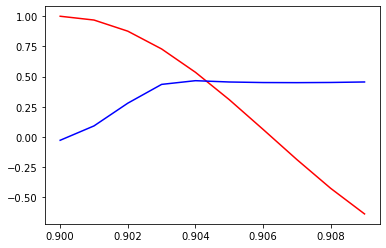

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0210, -0.1749, -0.4577, -0.6330, -0.6765, -0.6600, -0.6256, -0.5892,
        -0.5598, -0.5411], grad_fn=<ViewBackward0>)


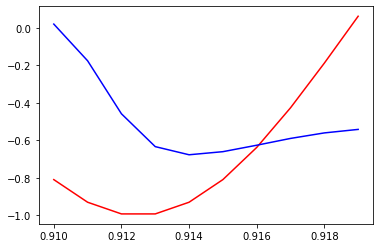

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0839,  0.1423,  0.3676,  0.4773,  0.4980,  0.4946,  0.4807,  0.4630,
         0.4452,  0.4298], grad_fn=<ViewBackward0>)


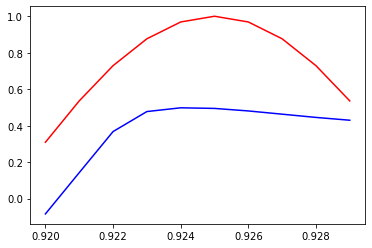

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0461, -0.2204, -0.5563, -0.7510, -0.8152, -0.8265, -0.8220, -0.8086,
        -0.7877, -0.7618], grad_fn=<ViewBackward0>)


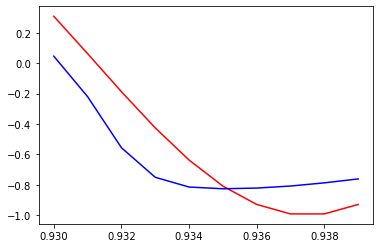

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0637,  0.1339,  0.3454,  0.4771,  0.5341,  0.5623,  0.5777,  0.5840,
         0.5825,  0.5730], grad_fn=<ViewBackward0>)


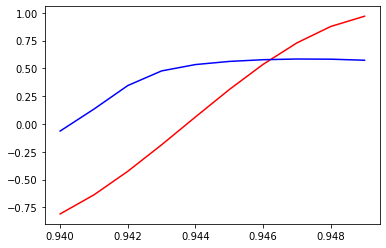

tensor([ 1.0000,  0.9686,  0.8763,  0.7289,  0.5358,  0.3090,  0.0628, -0.1874,
        -0.4258, -0.6374])
tensor([-0.0281,  0.0985,  0.2981,  0.4476,  0.4631,  0.4444,  0.4357,  0.4326,
         0.4335,  0.4385], grad_fn=<ViewBackward0>)


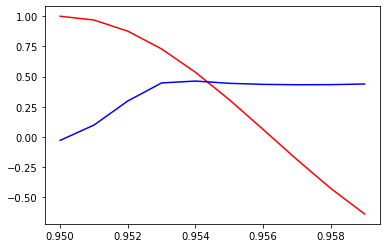

tensor([-0.8090, -0.9298, -0.9921, -0.9921, -0.9298, -0.8090, -0.6374, -0.4258,
        -0.1874,  0.0628])
tensor([ 0.0278, -0.1782, -0.4710, -0.6418, -0.6758, -0.6401, -0.5747, -0.5080,
        -0.4637, -0.4432], grad_fn=<ViewBackward0>)


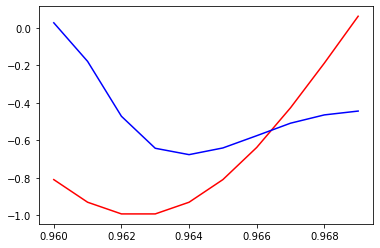

tensor([0.3090, 0.5358, 0.7290, 0.8763, 0.9686, 1.0000, 0.9686, 0.8763, 0.7290,
        0.5358])
tensor([-0.0938,  0.1266,  0.3558,  0.4830,  0.5101,  0.5042,  0.4836,  0.4570,
         0.4300,  0.4062], grad_fn=<ViewBackward0>)


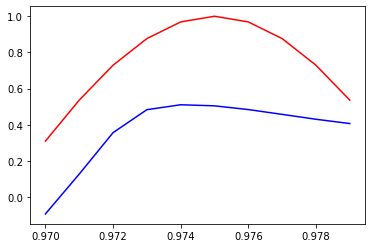

tensor([ 0.3090,  0.0628, -0.1874, -0.4258, -0.6374, -0.8090, -0.9298, -0.9921,
        -0.9921, -0.9298])
tensor([ 0.0576, -0.2125, -0.5701, -0.7869, -0.8621, -0.8804, -0.8822, -0.8739,
        -0.8559, -0.8297], grad_fn=<ViewBackward0>)


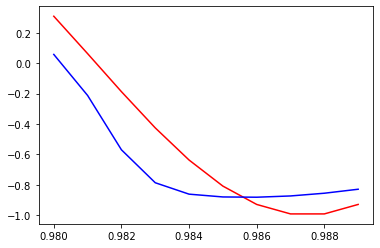

tensor([-0.8090, -0.6374, -0.4258, -0.1874,  0.0628,  0.3090,  0.5358,  0.7290,
         0.8763,  0.9686])
tensor([-0.0740,  0.1171,  0.3232,  0.4667,  0.5393,  0.5777,  0.5990,  0.6085,
         0.6073,  0.5954], grad_fn=<ViewBackward0>)


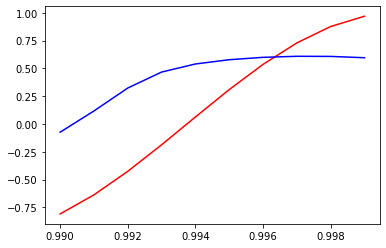

In [26]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

model = BasicLSTM(INPUT_SIZE, 32, INPUT_SIZE, 1, 1)
loss_fn = torch.nn.MSELoss(size_average=False)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

plt.figure(1, figsize=(12, 5))
plt.ion()

hist = np.zeros(100)
batch_first = True

len_seq = 10
n_samples = 100
step = 0.001
a = np.arange(0,len_seq*n_samples*step, step, dtype=np.float32)
a = np.reshape(a,(n_samples,len_seq))

sin_seq = np.sin(a*2*np.pi*40)
cos_seq = np.cos(a*2*np.pi*40)

for t in range(0,100): 
    model.zero_grad()
    
    x_np = np.array(sin_seq[t,:])
    y_np = np.array(cos_seq[t,:])
    
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])
    y = torch.from_numpy(y_np)
    
    lengths_np = np.ones(1) * 10
    lengths = torch.from_numpy(lengths_np)
    
    y_pred = model(x, lengths_np.tolist(), batch_first)
    print(y)
    print(y_pred)
    loss = loss_fn(y_pred, y)
    hist[t] = loss.item()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    batch_first = False
    
    step_y = np.array(a[t,:])
    plt.plot(step_y, y_np.flatten(), 'r-')
    plt.plot(step_y, y_pred.data.numpy().flatten(), 'b-')
    plt.draw(); plt.pause(0.05)
    
plt.ioff()
plt.show()

# STEP 9 #

FSDD

In [71]:
def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.split('/')[1].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0][f[0].find('\\')+1:]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = librosa.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
    # Print dataset info
    print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ['0', '1', '2', '3', '4']
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [72]:
path = './recordings'
X_train, X_test, y_train, y_test, spk_train, spk_test = parser(path)

Total wavs: 3000


In [73]:
print("X_train has samples ", np.shape(X_train),", with features ", np.shape(X_train[0]))
print("X_test has samples ", np.shape(X_test), ", with features ", np.shape(X_test[0]))

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state = 1)

print("After splitting to validation set X_train has samples ", np.shape(X_tr), ", with features ", np.shape(X_tr[0]))
print("X_val has samples ", np.shape(X_val), ", with features ", np.shape(X_val[0]))

X_train has samples  (2700,) , with features  (50, 6)
X_test has samples  (300,) , with features  (20, 6)
After splitting to validation set X_train has samples  (2160,) , with features  (28, 6)
X_val has samples  (540,) , with features  (28, 6)


In [99]:
# files = glob(os.path.join('./recordings', '*.wav'))
# fnames = [f.split('/')[1].split('.')[0].split('_') for f in files]
# fnames[0][1]#[fnames[0][0].find('\\')+1:]

# STEP 10 #
Next, we will identify digits with GMM-HMM (Gaussian Mixture Models - Hidden Markov Models). We use Python's pomegranate library, which we then install. First, we will initialize a GMM-HMM model for each digit. We use and extend the hmm.py function of the auxiliary hardware, which we then declare as init_GMM_HMM_model. The model we implement inside it is of the left-right form with a transition matrix of the form [[0.5,0.5,0, ..., 0], [0,0.5,0.5,0, ..., 0] ,. .., [0,0, ..., 0,0.5,0.5], [0,0 ,, ..., 1]] (dimensions (n_states, n_states)), starting probability matrix [1,0 ,. .., 0] (dimensions (1, n_states)), ending probability matrix [0, ..., 0,1] (dimensions (1, n_states)). We give these tables as input to the ready-made function of the HiddenMarkovModel pomegranate, along with a list of probability distributions for HMM states, which are calculated with a mixture of Gaussian distributions (GMM).

To calculate the GMM, input is given to init_GMM_HMM_model, except n_states, n_mixtures, a numpy array containing all the sample - one-digit attributes. Before tilting the function for each digit, we create a numpy attribute table for each digit and save them as elements of the allsamples_d_np list. We initialize the models for all ten digits, calling init_GMM_HMM_model with n_states = 2, n_mixtures = 2 and the corresponding numpy table corresponding to the digit. This initialization is done supervised initially, with random values ​​for n_states, n_mixtures to confirm the function of the function created by the models. The parameters will then be given values ​​after testing to improve the performance of the models.

In [ ]:
!pip install --user pomegranate --upgrade

In [1]:
from pomegranate import *

In [74]:
def init_GMM_HMM_model(X,n_states,n_mixtures):
    if n_mixtures == 1:
        gmm = False
    else:
        gmm = True # whether to use GMM or plain Gaussian

    dists = [] # list of probability distributions for the HMM states
    for i in range(n_states):
        if gmm:
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, X)
        else:
            a = MultivariateGaussianDistribution.from_samples(X)
        dists.append(a)

    trans_mat = np.zeros((n_states,n_states)) # your transition matrix
    for i in range(n_states):
        for j in range(n_states):
            if j>=i and j<=i+1:
                if j==i and j==n_states-1:
                    trans_mat[i][j]=1
                else:
                    trans_mat[i][j]=0.5
    
    starts = [0.0]*n_states # your starting probability matrix
    starts[0]=1
    
    ends = [0.0]*n_states # your ending probability matrix
    ends[n_states-1]=1
    
    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)]) 
    return model

In [75]:
allsamples_d_list = [None]*10
allsamples_d_np = [None]*10

for label in np.unique(y_tr):
    indices = [i for i, x in enumerate(y_tr) if x == label]
    tmp = []

    for i in indices:
        tmp.append(X_tr[i])

    allsamples_d_list[label] = np.array(tmp)
    allsamples_d_np[label] = np.concatenate(allsamples_d_list[label], axis=0)

model_init = [None]*10
for label in np.unique(y_tr):
    model_init[label] = init_GMM_HMM_model(allsamples_d_np[label], 2, 2)

# STEP 11 #
In this phase, the 10 models, which we initialized above, are trained, using the Expectation Maximization algorithm

In [76]:
models = [None]*10
for label in np.unique(y_tr):
    models[label]=model_init[label].fit(allsamples_d_list[label], max_iterations=5)

# STEP 12 #
We create the predict_score_HMM function, which calculates for each of the 10 GMM-HMM models we create for each digit, and for each pronunciation, which belongs to the set of data for identification, the log likelihood logarithm with the algorithm viterbi. From the logs calculated for each sample and each model, the maximum is selected which corresponds to the class in which the sample is classified. The function therefore calculates all the predictions for the set of samples given to it as an argument as well as the success rate of the classification and returns them.

Initially, we will perform the recognition only in the validation set, changing the training parameters of the model in order to reach the best possible result. We create three loops, in which we get values ​​for n_state from 1-4, for n_mixtures from 1-5 and for Niter from 1-5 and for each combination we initialize and train the 10 GMM-HMM models and calculate the success rates in validation set via predict_score_HMM. Finally, we print the parameters that led to the largest percentage in the validation set. This process, because it is quite time consuming, has been placed in comments, so that it runs only in case we want to see its results and remove them.

In [82]:
def predict_score_HMM(X,y):
    y_predict = [None]*len(y)
    for i in range(0,len(y)):
        logp_sample = [None]*10
        for label in np.unique(y):
            logp, _ = models[label].viterbi(X[i])
            print(label,logp_sample)
#             logp_sample[label-1] = logp
            logp_sample[label] = logp

        y_predict[i] = np.argmax(logp_sample)
    print(y_predict)
    hits_clas = 0
    for i in range(0,len(y)):
        hits_clas = hits_clas + (y_predict[i] == y[i])

    srate = hits_clas / len(y)
    return y_predict,srate

In [83]:
'''
max_rate=0.0
max_state=0
max_mix=0
max_Ni=0
for state in range(1,5):
        for mixture in range(1,6):
            for Ni in range(1,6):
                for label in np.unique(y_tr):
                    model = init_GMM_HMM_model(allsamples_d_np[label], state, mixture)
                    models[label]=model.fit(allsamples_d_list[label], max_iterations=Ni) 
                    
                y_predict,srate = predict_score_HMM(X_val,y_val)
                
                if srate>max_rate:
                    max_rate = srate
                    max_state = state
                    max_mix = mixture
                    max_Ni = Ni
                print('State ',state,', Mix ',mixture, ', Max_it ',Ni, ', rate',srate)
print('Best params:','State ',max_state,', Mix ',max_mix, ', Max_it ',max_Ni, ', rate',max_rate) '''

"\nmax_rate=0.0\nmax_state=0\nmax_mix=0\nmax_Ni=0\nfor state in range(1,5):\n        for mixture in range(1,6):\n            for Ni in range(1,6):\n                for label in np.unique(y_tr):\n                    model = init_GMM_HMM_model(allsamples_d_np[label], state, mixture)\n                    models[label]=model.fit(allsamples_d_list[label], max_iterations=Ni) \n                    \n                y_predict,srate = predict_score_HMM(X_val,y_val)\n                \n                if srate>max_rate:\n                    max_rate = srate\n                    max_state = state\n                    max_mix = mixture\n                    max_Ni = Ni\n                print('State ',state,', Mix ',mixture, ', Max_it ',Ni, ', rate',srate)\nprint('Best params:','State ',max_state,', Mix ',max_mix, ', Max_it ',max_Ni, ', rate',max_rate) "

In [84]:
state = 4
mixture = 5
Ni = 2
for label in np.unique(y_tr):
    model = init_GMM_HMM_model(allsamples_d_np[label], state, mixture)
    models[label]=model.fit(allsamples_d_list[label], max_iterations=Ni) 

y_predict_val,srate = predict_score_HMM(X_val,y_val)
print('Best params calculated on validation set are:','State ',state,', Mix ',mixture, ', Max_it ',Ni, ', rate',srate*100,'%')

0 [None, None, None, None, None, None, None, None, None, None]
1 [-127.11933633937555, None, None, None, None, None, None, None, None, None]
2 [-127.11933633937555, -124.95528097428594, None, None, None, None, None, None, None, None]
3 [-127.11933633937555, -124.95528097428594, -126.27924169089545, None, None, None, None, None, None, None]
4 [-127.11933633937555, -124.95528097428594, -126.27924169089545, -120.44849812771523, None, None, None, None, None, None]
5 [-127.11933633937555, -124.95528097428594, -126.27924169089545, -120.44849812771523, -113.3158383883221, None, None, None, None, None]
6 [-127.11933633937555, -124.95528097428594, -126.27924169089545, -120.44849812771523, -113.3158383883221, -106.3140001714873, None, None, None, None]
7 [-127.11933633937555, -124.95528097428594, -126.27924169089545, -120.44849812771523, -113.3158383883221, -106.3140001714873, -116.92537043414939, None, None, None]
8 [-127.11933633937555, -124.95528097428594, -126.27924169089545, -120.4484981277

In [85]:
y_predict_test,srate = predict_score_HMM(X_test,y_test)
print('Success rate on test set is ',srate*100,'%',', with parameters: State ',state,', Mix ',mixture, ', Max_it ',Ni)

hits_per_class = [0]*10
for i in range(0,len(y_predict_test)):
    hits_per_class[y_predict_test[i]]=hits_per_class[y_predict_test[i]]+1

print('From the ',len(y_predict_test), ' samples we have ', hits_per_class, ' hits per class, first element is the hit for class 0, etc')

0 [None, None, None, None, None, None, None, None, None, None]
1 [-81.94652081602003, None, None, None, None, None, None, None, None, None]
2 [-81.94652081602003, -76.33409347369414, None, None, None, None, None, None, None, None]
3 [-81.94652081602003, -76.33409347369414, -88.52630635826996, None, None, None, None, None, None, None]
4 [-81.94652081602003, -76.33409347369414, -88.52630635826996, -84.04164201179792, None, None, None, None, None, None]
5 [-81.94652081602003, -76.33409347369414, -88.52630635826996, -84.04164201179792, -84.47466765695958, None, None, None, None, None]
6 [-81.94652081602003, -76.33409347369414, -88.52630635826996, -84.04164201179792, -84.47466765695958, -89.92188509510497, None, None, None, None]
7 [-81.94652081602003, -76.33409347369414, -88.52630635826996, -84.04164201179792, -84.47466765695958, -89.92188509510497, -91.74558503821731, None, None, None]
8 [-81.94652081602003, -76.33409347369414, -88.52630635826996, -84.04164201179792, -84.47466765695958, -

# STEP 13 #
Next, we form 2 tables which will contain the results of the procedure of step 12 for the validation and the test set. More specifically, we make a Confusion Matrix table, which is of the format 10x10, and in its rows contains the digits to be sorted, while in its columns the classes in which they were sorted. This is done using the ready-made confusion_matrix function of sklearn.metrics, which takes as its argument the model predictions, the actual labels of each sample as well as the classes. We also use the plot_confusion_matrix utility function to visualize the Confusion Matrix. In the main diagonal are the accurate predictions for each set, as they were presented in the previous step.

In [86]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[25  8  1  0  0  2  0  2  4 12]
 [ 7 21  0  2  0  4  4  3  1 12]
 [ 1  8  6  2  4  4  8 14  4  3]
 [ 3  4  4  7  1  5  3  4 11 12]
 [ 7 11  0  4 12  7  3  2  3  5]
 [ 3  4  0  0  1 18  3  7  9  9]
 [ 0  2  2  2  3  3 29  6  7  0]
 [ 1  3  4  4  1  5 15 13  3  5]
 [ 2  4  1  1  2  2 17  1 23  1]
 [ 2  2  0  0  0  5  2  1  5 37]]


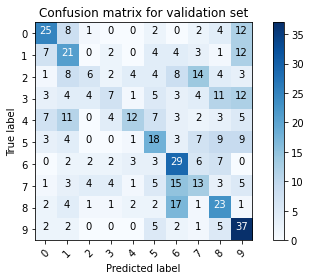

In [87]:
#for val set
classes = np.unique(y_val)
cm = confusion_matrix(y_val, y_predict_val,classes)
fig = plt.figure()
title='Confusion matrix for validation set'
plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[13  9  0  0  1  0  1  0  0  6]
 [ 2 15  0  2  0  4  0  2  2  3]
 [ 1  5  4  1  0  2  3  6  5  3]
 [ 1  8  0  4  3  2  4  3  3  2]
 [ 0  6  0  2  4  7  0  5  0  6]
 [ 3  0  0  0  2 11  3  2  5  4]
 [ 0  2  0  0  0  3 16  4  5  0]
 [ 2  2  2  1  0  3 10  6  2  2]
 [ 0  5  0  0  0  2  5  3 11  4]
 [ 2  3  0  0  0  2  1  0  3 19]]


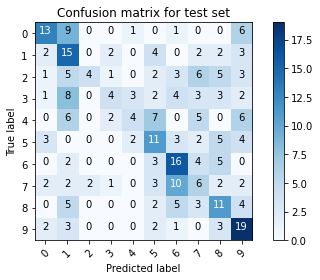

In [88]:
#for test set
classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_predict_test,classes)
fig = plt.figure()
title='Confusion matrix for test set'
plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues)

# STEP 14 #
In this step we trained a Retrospective Neural Network on the training set, using the validation set to configure the hyperparameters. First, we create a simple, one-way LSTM. Specifically, we used the helper code (lstm.py) to implement the network and created the BasicLSTM class which was based on the given code. The forward method was completed, in which we pass the whole batch through nn.LSTM while then we keep only the last output (via the last_timestep method of the class) to pass it through the rest of the network. The FrameLevelDataset class with the zero_pad_and_stack method was used to bring the sample sequences of a batch to the same size, making zero padding. We also used pack_padded_sequence in model training and for this purpose we sort the sequences of each batch in descending order of length (keeping the corresponding labels when sorting) to zero_pad_and_stack.

In addition, we created two functions outside of classes, get_pred, eval_pred. The first one takes the samples with the sequences of a batch (in the form of a list from numpy arrays) and their corresponding labels and calls the zero_pad_and_stack (which returns the processed batch in 3D numpy array, the lengths of the sequences in the batch and their labels after classification). Converts the returned batch along with the lengths into a torch tensor format and calls BasicLSTM. Returns the output of the neuron and the actual labels of each sample. Eval_pred was created to generate from the output of the neuron the predictions for the labels of each sample. For this purpose it calls get_pred and in the output of the neuron (which is in the form of batch size for 10 classes) it applies np.argmax per line (ie sample) to return the label with the highest value. Predictions for all samples, actual label values ​​as well as neuronal output are reversed.

In the main cell that includes the train loop we first define our model with input_dim = 6 (number of features), output_dim = 10 (different tags), bidirectional = False. We use nn.CrossEntropyLoss for loss function and torch.optim.SGD as optimizer. For the number of seasons we have defined, we divide in each of them the whole X_train into batches (depending on the size of the batch size) we call get_pred and find the loss between the output and the actual labels of the batch samples. We do back propagation in error with loss.backward (). For the renewal of the neuron weights we use the optimizer.step (). We calculate the training loss in each season, summing the individual losses of each batch and dividing by their number and printing it. In each season, after the training is done through the batches of the training set, the model is evaluated in the validation set by calling eval_pred and the accuracy_score for the predictions of the samples. In addition, the loss is calculated and printed in the validation set.

LSTM improvements

We added to the neural dropout and L2 regularization as follows: setting the dropout parameter to nn.LSTM defined in the init method of the BasicLSTM class and setting the weight_decay parameter to the optimizer respectively.
The dropout works as follows (according to the paper "Improving neural networks by preventing co-adaptation of feature detectors": any neural node (except those in the last layer) can be disabled at any time step with a probability of p , so that it does not interact with the rest of the network (weights can not be updated or affect the learning of other nodes in the network). overfitting is reduced and neurons in general learn to recognize features that are most useful in final recognition.
L2 regularization practically adds to the loss function we use a term, called regularization term. Due to the addition of this term, the values ​​of the weight tables are reduced. This is because it has been shown that a neural network with lower weights leads to simpler models. This reduces overfitting. In the general case that we have a cost function 𝐶0 and λ is the weight of regularization, it will be converted to:
𝐶 = 𝐶0 + λ2𝑛∑𝑤𝑤2
 
We also use the Early Stopping technique to avoid wasting our computer resources. Early Stopping is a way to decide if our model is improving over the epochs or if it remains stagnant and therefore extra steps do not make sense. In this case we used the performance of the model on the validation data as metric. Also every time we find a better model, we save it in one file so we can access it later (Checkpoint)
We also present the model with pack_padded_sequence directly in the tutorial. The LSTM can ignore the zeros when training the network, through this representation that allows it to know the true number of elements of each sequence. This leads to improved network speed.

# Basic LSTM #

In [89]:
import os
from torch.utils.data import Dataset

class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        #self.lengths =  # Find the lengths 
        lengths = []
        for i in range(len(feats)):
            lengths.append(feats[i].shape[0])
        
        lengths = np.array(lengths)
        idx = np.argsort(lengths)[::-1]
        self.lengths = lengths
        
        self.labels = np.array(labels).astype('int64')
            
        self.feats = self.zero_pad_and_stack(feats)
    
    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        n_max = max([a.shape[0] for a in x])
        
        #padded = []
        # --------------- Insert your code here ---------------- #
        padded = np.zeros((len(x), n_max, x[0].shape[1]))
        
    
        for i in range(len(x)):
            padded[i:i + 1,:x[i].shape[0], :] = x[i]
        
        idx = np.argsort(self.lengths)[::-1]
        
        return padded[idx, :, :],self.lengths[idx],self.labels[idx]

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)

In [90]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.lstm = nn.LSTM(self.input_dim, self.rnn_size, self.num_layers,bidirectional=self.bidirectional,dropout=0.1)
        self.linear = nn.Linear(self.feature_size, self.output_dim)
        
    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        packed = pack_padded_sequence(x, lengths,batch_first=True)
        out_packed, (ht, ct) = self.lstm(packed)
        out_unpacked, _ = pad_packed_sequence(out_packed,batch_first=True)
        
        last_outputs = self.last_timestep(out_unpacked, lengths, self.bidirectional)
        last_outputs = self.linear(last_outputs)
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [91]:
# Early stopping

class EarlyStopping(object):
    
    """
    EarlyStopping can be used to stop te training if no improvement after a given number of events
    
    Args: 
        patience(int):
            Number of events to wait if no improvement and then stop the training
        
        mode(string):
            There are two modes:
                min, for looking for minumums
                max, for looking for maximums
                
        min_delta(float):
            The threshold of improvement
            
        percentage(boolean):
            Defines whether min_delta is a percentage or an absolute number
    """
    
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0 # counter of no events
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    """
    Returns True if the Early Stopping has to be enforced, otherwise returns False.
    """
    
    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [92]:
def get_pred(x,y):
    padded_x,lengths,labels = FrameLevelDataset(x, y).zero_pad_and_stack(x)
    padded_x = torch.tensor(padded_x).float()
    lengths = torch.tensor(lengths).long()
    output = model(padded_x,lengths)
    return output,torch.tensor(labels, dtype=torch.long)

In [93]:
def eval_pred(x,y):
    output_tensor, labels_tensor = get_pred(x, y)
    batch_pred = output_tensor.data.numpy().argmax(1)
    labels_y = labels_tensor.data.numpy()
    return batch_pred, labels_y, output_tensor, labels_tensor

In [94]:
# Create checkpoint
# Save our best model on a file
def save_checkpoint(model, path='./lab2_lstm.pt'):
    torch.save({'state_dict': model.state_dict()}, path)

In [95]:
# Load checkpoint (best model)
def load_checkpoint(path, model):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [96]:
from sklearn.metrics import accuracy_score

rnn_size = 50
num_layers = 2

model = BasicLSTM(X_tr[0].shape[1], rnn_size, len(np.unique(y_tr)), num_layers, False)

print('Training Loop for Basic LSTM')

epochs = 50
batch_size = 30
LR = 1.0
best_score = 0

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.000001,lr=LR)
earlystopping = EarlyStopping(mode='max', min_delta=0.01, patience=8)

train_loss_all=[]
val_loss_all=[]
idx = np.arange(len(X_tr))    

for epoch in range(epochs):
    np.random.shuffle(idx)
    X_tr = [X_tr[i] for i in idx]
    y_tr = [y_tr[i] for i in idx]
    
    #train loop
    current_batch = 0
    train_loss = 0.0

    for iteration in range(len(y_tr) // batch_size):
        batch_x = X_tr[current_batch: current_batch + batch_size]
        batch_y = y_tr[current_batch: current_batch + batch_size]
        
        current_batch += batch_size
        optimizer.zero_grad()
            
        if len(batch_x) > 0:
            output,y = get_pred(batch_x,batch_y)
            loss = criterion(output,y)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss
    train_loss_all.append(train_loss/(len(X_tr)/batch_size))
    
    #validation loop
    batch_pred, labels_y, output_tensor, labels_tensor = eval_pred(X_val,y_val)
    val_loss = criterion(output_tensor,labels_tensor)
    val_loss_all.append(val_loss)
    #f1 = f1_score(labels_y, batch_pred, average='weighted')
    f1 = accuracy_score(labels_y, batch_pred)
    if (f1 > best_score):
        best_score = f1
        save_checkpoint(model)
    
    
    print ('Epoch %d from %d, Train loss: %.2f' %(epoch + 1, epochs, train_loss/(len(X_tr)/batch_size)))
    print ('Epoch %d from %d, Validation loss: %.2f' %(epoch + 1, epochs, val_loss))
    print('Score in validation set is: %d %%' % (100 * f1))
    print('--------------------------------')
    
    if(earlystopping.step(f1) is True):
        print('Early stopping the training cycle on epoch %d .' %(epoch+1))
        print('Best score %d %%' % (100 * best_score) )
        break

Training Loop for Basic LSTM
Epoch 1 from 50, Train loss: 1.98
Epoch 1 from 50, Validation loss: 1.70
Score in validation set is: 35 %
--------------------------------
Epoch 2 from 50, Train loss: 1.45
Epoch 2 from 50, Validation loss: 1.29
Score in validation set is: 49 %
--------------------------------
Epoch 3 from 50, Train loss: 1.19
Epoch 3 from 50, Validation loss: 1.03
Score in validation set is: 60 %
--------------------------------
Epoch 4 from 50, Train loss: 0.80
Epoch 4 from 50, Validation loss: 0.69
Score in validation set is: 75 %
--------------------------------
Epoch 5 from 50, Train loss: 0.46
Epoch 5 from 50, Validation loss: 0.43
Score in validation set is: 84 %
--------------------------------
Epoch 6 from 50, Train loss: 0.39
Epoch 6 from 50, Validation loss: 0.41
Score in validation set is: 85 %
--------------------------------
Epoch 7 from 50, Train loss: 0.28
Epoch 7 from 50, Validation loss: 0.22
Score in validation set is: 92 %
-------------------------------

In [104]:
train_loss_all[0].detach().numpy()

array(1.9793099, dtype=float32)

Text(0, 0.5, 'Loss')

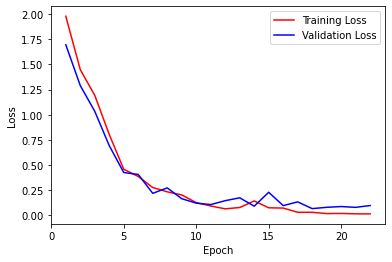

In [106]:
epoch_count=range(1,len(train_loss_all)+1)
plt.plot(epoch_count,[i.detach().numpy() for i in  train_loss_all],'r-')
plt.plot(epoch_count,[i.detach().numpy() for i in val_loss_all],'b-')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [107]:
model = BasicLSTM(X_tr[0].shape[1], rnn_size, len(np.unique(y_tr)), num_layers, False)
model = load_checkpoint('./lab2_lstm.pt', model)

In [108]:
#accuracy score for validation set
pred_val, labels_y_val, _, _ = eval_pred(X_val,y_val)
f1 = accuracy_score(labels_y_val, pred_val)
print('Score in validation set is: %d %%' % (100 * f1))

Score in validation set is: 98 %


In [109]:
#accuracy score for test set
pred_test, labels_y_test, _, _ = eval_pred(X_test,y_test)
f1 = accuracy_score(labels_y_test, pred_test)
print('Score in test set is: %d %%' % (100 * f1))

Score in test set is: 96 %


Confusion matrix, without normalization
[[52  0  0  0  1  0  1  0  0  0]
 [ 0 53  0  0  0  0  0  0  0  1]
 [ 1  0 52  1  0  0  0  0  0  0]
 [ 0  0  1 52  0  0  1  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  2  0  0 51  0  1  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0  0  0 54]]


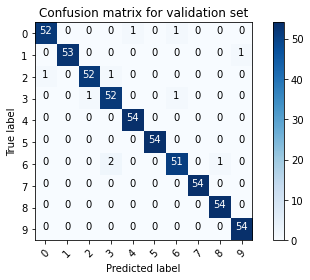

In [110]:
#confusion matrix for val set
classes = np.unique(y_val)
cm = confusion_matrix(labels_y_val, pred_val,classes)
fig = plt.figure()
title='Confusion matrix for validation set'
plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[28  0  2  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  1  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 0  0  0  2  1  0 27  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  5  0 25  0]
 [ 0  0  0  0  0  0  0  0  0 30]]


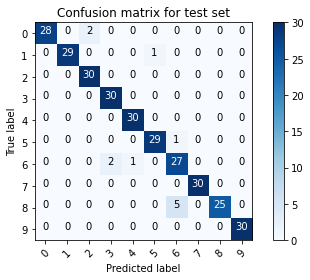

In [111]:
#confusion matrix for test set
classes = np.unique(y_test)
cm = confusion_matrix(labels_y_test, pred_test,classes)
fig = plt.figure()
title='Confusion matrix for test set'
plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues)

# Bidirectional LSTM #
For the conversion of Basic LSTM to Bidirectional we give the True value when calling the model in the bidirection parameter (for the simple LSTM we give false). Also, inside the init in case we have bidirectional = True we double the hidden size given as an argument to nn.Linear (applied to the forward) and in addition bidirectional = True is set when calling nn.LSTM.

Bidirectional LSTMs connect two hidden layers in opposite directions to the same output. In this form, the output layer can receive information from past and future states simultaneously. They were introduced to increase the amount of input information available on the network, which makes training and outcomes better.

Below are the same hyperparameters used for Basic LSTM, except that we have reduced the number of seasons, as the network performance is improving faster than before. Then, the training and the validation loss in each season are printed and the error diagram in the training set and the validation set for each training season. The success rate of the best model in the validation and test set are presented, as well as the corresponding confusion matrices.

In [112]:
rnn_size = 50
num_layers = 2

model = BasicLSTM(X_tr[0].shape[1], rnn_size, len(np.unique(y_tr)), num_layers, True)

print('Training Loop for Bidirectional LSTM')

epochs = 20
batch_size = 30
LR = 1.0
best_score = 0

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.000001,lr=LR)
earlystopping = EarlyStopping(mode='max', min_delta=0.01, patience=3)


train_loss_all=[]
val_loss_all=[]
idx = np.arange(len(X_tr))    

for epoch in range(epochs):
    np.random.shuffle(idx)
    X_tr = [X_tr[i] for i in idx]
    y_tr = [y_tr[i] for i in idx]
    
    #train loop
    current_batch = 0
    train_loss = 0.0

    for iteration in range(len(y_tr) // batch_size):
        batch_x = X_tr[current_batch: current_batch + batch_size]
        batch_y = y_tr[current_batch: current_batch + batch_size]
        
        current_batch += batch_size
        optimizer.zero_grad()
            
        if len(batch_x) > 0:
            output,y = get_pred(batch_x,batch_y)
            loss = criterion(output,y)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss
    train_loss_all.append(train_loss/(len(X_tr)/batch_size))
    
    #validation loop
    batch_pred, labels_y, output_tensor, labels_tensor = eval_pred(X_val,y_val)
    val_loss = criterion(output_tensor,labels_tensor)
    val_loss_all.append(val_loss)
    #f1 = f1_score(labels_y, batch_pred, average='weighted')
    f1 = accuracy_score(labels_y, batch_pred)
    if (f1 > best_score):
        best_score = f1
        save_checkpoint(model, 'lab2_bidirectional_lstm.pt')
        
    
    print ('Epoch %d from %d, Train loss: %.2f' %(epoch + 1, epochs, train_loss/(len(X_tr)/batch_size)))
    print ('Epoch %d from %d, Validation loss: %.2f' %(epoch + 1, epochs, val_loss))
    print('Score in validation set is: %d %%' % (100 * f1))
    print('--------------------------------')
    
    if(earlystopping.step(f1) is True):
        print('Early stopping the training cycle on epoch %d.' %(epoch+1))
        print('Best score %d %%' % (100 * best_score) )
        break

Training Loop for Bidirectional LSTM
Epoch 1 from 20, Train loss: 1.54
Epoch 1 from 20, Validation loss: 0.69
Score in validation set is: 76 %
--------------------------------
Epoch 2 from 20, Train loss: 0.60
Epoch 2 from 20, Validation loss: 0.32
Score in validation set is: 90 %
--------------------------------
Epoch 3 from 20, Train loss: 0.46
Epoch 3 from 20, Validation loss: 0.37
Score in validation set is: 86 %
--------------------------------
Epoch 4 from 20, Train loss: 0.20
Epoch 4 from 20, Validation loss: 0.17
Score in validation set is: 93 %
--------------------------------
Epoch 5 from 20, Train loss: 0.15
Epoch 5 from 20, Validation loss: 0.19
Score in validation set is: 93 %
--------------------------------
Epoch 6 from 20, Train loss: 0.10
Epoch 6 from 20, Validation loss: 0.13
Score in validation set is: 96 %
--------------------------------
Epoch 7 from 20, Train loss: 0.07
Epoch 7 from 20, Validation loss: 0.17
Score in validation set is: 94 %
-----------------------

In [113]:
model = BasicLSTM(X_tr[0].shape[1], rnn_size, len(np.unique(y_tr)), num_layers, True)
model = load_checkpoint('lab2_bidirectional_lstm.pt', model)

Text(0, 0.5, 'Loss')

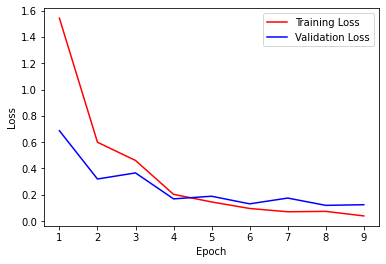

In [114]:
epoch_count=range(1,len(train_loss_all)+1)
plt.plot(epoch_count,[i.detach().numpy() for i in  train_loss_all],'r-')
plt.plot(epoch_count,[i.detach().numpy() for i in val_loss_all],'b-')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [115]:
#accuracy score for validation set
pred_val, labels_y_val, _, _ = eval_pred(X_val,y_val)
f1 = accuracy_score(labels_y_val, pred_val)
print('Score in validation set is: %d %%' % (100 * f1))

Score in validation set is: 96 %


Confusion matrix, without normalization
[[53  0  0  0  0  0  1  0  0  0]
 [ 0 52  0  0  1  0  0  1  0  0]
 [ 1  1 49  0  2  0  0  1  0  0]
 [ 0  0  2 52  0  0  0  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  3  0  0 49  0  2  0]
 [ 0  1  1  0  0  0  0 52  0  0]
 [ 0  0  0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0  0  1 53]]


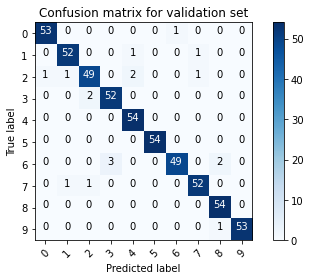

In [116]:
#confusion matrix for val set
classes = np.unique(y_val)
cm = confusion_matrix(labels_y_val, pred_val,classes)
fig = plt.figure()
title='Confusion matrix for validation set'
plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues)

In [117]:
#accuracy score for test set
pred_test, labels_y_test, _, _ = eval_pred(X_test,y_test)
f1 = accuracy_score(labels_y_test, pred_test)
print('Score in test set is: %d %%' % (100 * f1))

Score in test set is: 98 %


Confusion matrix, without normalization
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  1  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  1  0  0  0 29  0  0  0  0]
 [ 0  0  0  1  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  1  0 29  0]
 [ 0  0  0  0  0  0  0  0  0 30]]


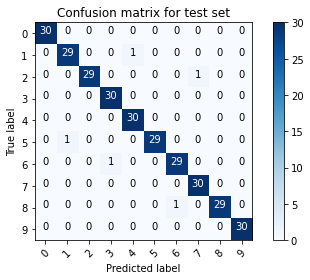

In [118]:
#confusion matrix for test set
classes = np.unique(y_test)
cm = confusion_matrix(labels_y_test, pred_test,classes)
fig = plt.figure()
title='Confusion matrix for test set'
plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues)

In [119]:
plt.show()